# Visualizations

## Packages, Presets and Loading the Data

In [26]:
import pandas as pd
import plotnine as pn
from plotnine import scale_y_continuous, scale_x_continuous
from plotnine import (ggplot, aes, geom_line, scale_color_manual, labs, theme, element_text, geom_vline)
from mizani.formatters import percent_format
import numpy as np
from IPython.display import display
from pathlib import Path
import re
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
import seaborn as sns

# Color palettes for visualization
JAMA_COLORS = [
    "#374E55FF",  # Dark slate gray
    "#8F44FF",    # Orange
    "#00A1D5FF",  # Blue
    "#B24745FF",  # Red
    "#79AF97FF",  # Sea green
    "#6A6599FF",  # Purple
    "#80796BFF",  # Brown
]

AAAS_COLORS = [
    "#3B4992FF",  # Navy blue
    "#EE0000FF",  # Red
    "#008B45FF",  # Green
    "#631879FF",  # Purple
    "#008280FF",  # Teal
    "#BB0021FF",  # Dark red
    "#5F559BFF",  # Light purple
    "#A20056FF",  # Magenta
    "#808180FF",  # Gray
    "#1B1919FF",  # Black
]

METRICS = ['eigenvalues', 'train_metrics', 'test_metrics', 'forgetting_metrics', 'overlaps']
ABLATION_TYPES = ['width', 'bs', 'lr']
SUBSPACE_TYPES = ['bulk', 'dominant', 'None']

ABLATION_PATTERN = r'../outputs/{}/width-(\d+)_bs-(\d+)_lr-(\d+\.?\d*)'
MAIN_PATTERN = r'../outputs/{}/subspace-{}'

@dataclass
class ExperimentDefaults:
    """Container for experiment default parameters."""
    width: int
    bs: int
    lr: float

THEME_ACADEMIC = pn.theme(
    text=pn.element_text(family="monospace"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=8),
    legend_title=pn.element_text(size=9),
    panel_background=pn.element_rect(fill="white"),
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    legend_position="right",
    legend_key_size=8,
    plot_margin=0.02,
    figure_size=(8, 4),
)

def add_step(eigenvalues: pd.DataFrame) -> pd.DataFrame:
    """Add step numbers to eigenvalue data based on eigenvalue_nr."""
    if eigenvalues.empty:
        return eigenvalues
    
    k = eigenvalues["eigenvalue_nr"].max()
    eigenvalues = eigenvalues.copy()
    eigenvalues['step'] = (eigenvalues.index // k) + 1
    return eigenvalues

def parse_experiment_params(folder_name: str, experiment_pattern: re.Pattern) -> Tuple[int, int, float]:
    """Extract width, batch size, and learning rate from experiment folder name."""
    match = experiment_pattern.match(folder_name)

    return int(match.group(1)), int(match.group(2)), float(match.group(3))

def load_main_results(experiment_name: str, defaults: ExperimentDefaults) -> Dict:
    """Load and process main experiment results from CSV files."""
    main_dict = {key: {subkey: {} for subkey in METRICS} for key in SUBSPACE_TYPES}
    
    for space in SUBSPACE_TYPES:
        metric_dir = Path(MAIN_PATTERN.format(experiment_name, space) + '/metrics')
        
        if metric_dir.is_dir():
            for csv_file in metric_dir.glob('*.csv'):
                df = pd.read_csv(csv_file)
                metric_name = csv_file.stem
                
                df['width'], df['bs'], df['lr'] = defaults.width, defaults.bs, defaults.lr
                
                if metric_name == 'eigenvalues':
                    df.reset_index(drop=True, inplace=True)
                    df = add_step(df)
                elif metric_name == 'train_metrics':
                    df = df.reset_index()
                    df.rename(columns={'index': 'training_step'}, inplace=True)
                    
                df['space'] = space
                df['experiment'] = experiment_name
                main_dict[space][metric_name] = df
                
    return main_dict

def get_task_boundaries(main_dict: Dict, space: str = 'bulk') -> np.ndarray:
    """Calculate indices where tasks change based on eigenvalues data."""
    try:
        temp = main_dict[space]['eigenvalues']
        return temp["step"].iloc[np.where(np.diff(temp['task_id']) != 0)[0]].values
    except KeyError as e:
        print(f"Missing required data: {str(e)}")
        return np.array([])

def load_ablation_results(experiment_name: str, defaults: ExperimentDefaults) -> Dict:
    """Load and process ablation study results from CSV files."""
    experiment_pattern = re.compile(ABLATION_PATTERN.format(f'{experiment_name}_ablation'))
    ablation_dict = {key: {subkey: {} for subkey in METRICS} for key in ABLATION_TYPES}
    
    ablation_path = Path('../outputs/'+f'{experiment_name}_ablation')
        
    for item in ablation_path.iterdir():
        if item.is_dir():
            width, bs, lr = parse_experiment_params(str(item), experiment_pattern)
            metric_dir = item / "metrics"
            
            if metric_dir.is_dir():
                for csv_file in metric_dir.glob('*.csv'):
                    df = pd.read_csv(csv_file)
                    metric_name = csv_file.stem
                    
                    if metric_name == 'eigenvalues':
                        df = add_step(df)
                    elif metric_name == 'train_metrics':
                        df = df.reset_index()
                        df.rename(columns={'index': 'training_step'}, inplace=True)
                        
                    df['width'], df['bs'], df['lr'] = width, bs, lr
                    df['experiment'] = experiment_name
                    df['space'] = 'bulk'
                    
                    if (width == defaults.width and bs == defaults.bs and lr != defaults.lr):
                        ablation_dict['lr'][metric_name][lr] = df
                    elif (width != defaults.width and bs == defaults.bs and lr == defaults.lr):
                        ablation_dict['width'][metric_name][width] = df
                    elif (width == defaults.width and bs != defaults.bs and lr == defaults.lr):
                        ablation_dict['bs'][metric_name][bs] = df
    
    return ablation_dict

# Default experimental configurations
PMNIST_DEFAULTS = ExperimentDefaults(width=100, bs=128, lr=0.01)
CIFAR10_DEFAULTS = ExperimentDefaults(width=32, bs=128, lr=0.001)
CIFAR100_DEFAULTS = ExperimentDefaults(width=32, bs=128, lr=0.001)

# Load results for each dataset
pmnist_ablation_dict = load_ablation_results('permuted_mnist', PMNIST_DEFAULTS)
pmnist_main_dict = load_main_results('permuted_mnist', PMNIST_DEFAULTS)

cifar10_ablation_dict = load_ablation_results('split_cifar10', CIFAR10_DEFAULTS)
cifar10_main_dict = load_main_results('split_cifar10', CIFAR10_DEFAULTS)

cifar100_ablation_dict = load_ablation_results('split_cifar100', CIFAR100_DEFAULTS)
cifar100_main_dict = load_main_results('split_cifar100', CIFAR100_DEFAULTS)

# Calculate task boundaries
PMNIST_BOUNDARIES = get_task_boundaries(pmnist_main_dict)
CIFAR10_BOUNDARIES = get_task_boundaries(cifar10_main_dict)
CIFAR100_BOUNDARIES = get_task_boundaries(cifar100_main_dict)

## Results

In [20]:
def plot_topk_next_topk_eigenvalues(eigenvalues, k, boundaries, facet=None):
    """
    Plot the top k and next top k eigenvalues over training steps, 
    with "Top-k" eigenvalues in distinct colors and "Next Top-k" in grey.
    """
    # Create a copy to avoid modifying the input DataFrame
    temp = eigenvalues.copy()
    
    # Create grouping column for faceting
    temp["group"] = "Next Top-k"  # Default value
    temp.loc[temp["eigenvalue_nr"] <= k, "group"] = "Top-k"
    
    # Create a new column for color mapping
    temp["color_group"] = temp.apply(
        lambda row: f"Top {row['eigenvalue_nr']}" if row["group"] == "Top-k" else "Next Top-" + f"{k}",
        axis=1
    )

    # Set the desired order for the legend
    # Example: ["Next Top-k", "Top-k 1", "Top-k 2", ..., "Top-k k"]
    topk_labels = [f"Top {i}" for i in range(1, k+1)]
    desired_order = topk_labels + ["Next Top-"+ f"{k}"]
    
    # Convert 'color_group' to a categorical type with the desired order
    temp["color_group"] = pd.Categorical(
        temp["color_group"],
        categories=desired_order,
        ordered=True
    )
    
    # Generate the "Paired" palette for Top-k eigenvalues
    paired_palette = sns.color_palette("Paired", k).as_hex()
    
    # Create a color mapping dictionary
    color_mapping = {f"Top {i}": paired_palette[i-1] for i in range(1, k+1)}
    color_mapping["Next Top-k"] = "grey"  # Assign grey to Next Top-k
    
    # Define the plot
    fig = (
        ggplot(temp, aes(x="step", y="value", color="color_group", group="color_group"))
        + geom_line(size=0.75, alpha=0.8)
        + scale_color_manual(values=color_mapping)
        + labs(
            x="Training Step",
            y="Eigenvalue",
            color="Eigenvalue"
        )
        + THEME_ACADEMIC
        + geom_vline(
            xintercept=boundaries,
            color="red",
            linetype="dashed",
            size=0.3
        )
    )
    
    return fig





def plot_max_eigenvalues_dom_bulk_plain(eigenvalues):
    """Plot the first eigenvalue over training steps for dominant, bulk, and plain SGD configurations."""
    # Define a mapping for the 'space' column
    space_mapping = {
        "None": "Plain SGD",
        "bulk": "SGD-BULK",
        "dominant": "SGD-DOM"
    }
    
    # Add a 'dataset' column to each DataFrame and map the 'space' values
    eigenvalues = eigenvalues.copy()
    eigenvalues["space"] = eigenvalues["space"].map(space_mapping)
    
    # Create the plot
    fig = (
        pn.ggplot(
            eigenvalues[eigenvalues['eigenvalue_nr'] == 1],
            pn.aes(
                x="step",
                y="value",
            ),
        )
        + pn.geom_line(size=0.75, alpha=0.5, color='blue')
        + pn.scale_color_brewer(type="qual", palette="Paired")
        + THEME_ACADEMIC
        + pn.facet_grid("~space", scales="free_x")  # Creates a grid with datasets as rows and spaces as columns
        + pn.theme(legend_position="none")
        + pn.labs(
            x="Training Step",
            y="Eigenvalue",
        )
    )
    
    return fig


def plot_train_metric(train_metric, boundaries):

    fil = ((train_metric['space'] == 'bulk') | (train_metric['space'] == 'dominant')) & (train_metric['task_id'] == 0)

    space_mapping = {
        "None": "Plain SGD",
        "bulk": "SGD-BULK",
        "dominant": "SGD-DOM"
    }
    
    # Add a 'dataset' column to each DataFrame and map the 'space' values
    train_metric = train_metric.copy()
    train_metric["space"] = train_metric["space"].map(space_mapping)


    fig = (
        pn.ggplot(
            train_metric[~fil],
            pn.aes(
                x="training_step",
                y="loss",
                color="factor(space)",
                group="space",
            ),
        )
        + pn.geom_line(size=0.75, alpha=0.7)
        + pn.scale_color_brewer(name="Optimizer",type="qual", palette="Paired")
        + pn.geom_vline(
            xintercept=boundaries, color="red", linetype="dashed", size=0.3 # reuse the same as for eigenvalues
        )
        + THEME_ACADEMIC
        + pn.labs(
            x="Training Step",
            y="Cross Entropy Loss",
        )
    )

    return fig

def plot_test_metric(test_metric):

    space_mapping = {
        "None": "Plain SGD",
        "bulk": "SGD-BULK",
        "dominant": "SGD-DOM"
    }
    
    # Add a 'dataset' column to each DataFrame and map the 'space' values
    test_metric = test_metric.copy()
    test_metric["space"] = test_metric["space"].map(space_mapping)
    
    fig = (
        pn.ggplot(
            test_metric,
            pn.aes(
                x="evaluated_at_task",
                y="accuracy",
                color="factor(task_id)",
                group="task_id",
            ),
        )
        + scale_x_continuous(
                breaks=range(test_metric['task_id'].max() + 1),  # Integer breaks
                labels=range(test_metric['task_id'].max() + 1)   # Integer labels
        )
        + pn.geom_line(size=0.75, alpha=0.8)
        + pn.geom_point(size = 0.8)
        + pn.scale_color_brewer(type="qual", palette="Paired")
        + pn.facet_wrap(f"~space")
        + THEME_ACADEMIC
        + pn.labs(
            x="Evaluated at Task",
            y="Accuracy (in percent)",
            color = 'Task'
        )
    )

    return fig

def topk_overlap(overlap, boundaries, space, k, ablation=None):

    overlap_long = pd.melt(
        overlap,
        id_vars=["task_id", "step", "space", f"{ablation}"] if ablation else ["task_id", "step", "space"],
        value_vars=[f"overlap_{space}"],
        var_name="metric",
        value_name="value",
    )

    # Create more descriptive labels for the overlap metrics
    overlap_long["metric"] = overlap_long["metric"].map(
        {f"overlap_{space}": f"Overlap of Top-{k} {space.upper()} Space"}
    )
        
    fig = (
        pn.ggplot(
            overlap_long,
            pn.aes(x="step", y="value", color="factor(task_id)", group="task_id"),
        )
        + pn.geom_line(alpha=1, size=0.75)
        + pn.scale_color_brewer(name="Task ID", type="qual", palette="Set3")
        + pn.geom_vline(
            xintercept=boundaries, color="red", linetype="dashed", size=0.3, alpha=0.5
        )
        + pn.scale_y_continuous(
            # labels=percent_format(),
            limits=[0, 1.01],
            breaks=np.arange(0, 1.1, 0.2),
        )
        + THEME_ACADEMIC
        + pn.labs(
            x="Training Step t1-t2",
            y="Overlap",
        )
    )

    if ablation:
        fig += pn.facet_wrap(f"~{ablation}")
    
    return fig


def overlap_ablation(overlap_main, overlap_ablation, boundaries, space, k):

    for ab in ABLATION_TYPES:

        temp = pd.concat(overlap_ablation[ab]['overlaps'].values(), ignore_index=True)
        temp = pd.concat([temp, overlap_main], ignore_index=True)
        
        fig = topk_overlap(temp, boundaries, space, k, ab)

        del temp

        display(fig)



### Top-K versus next Top-K Eigenvalues for SGD

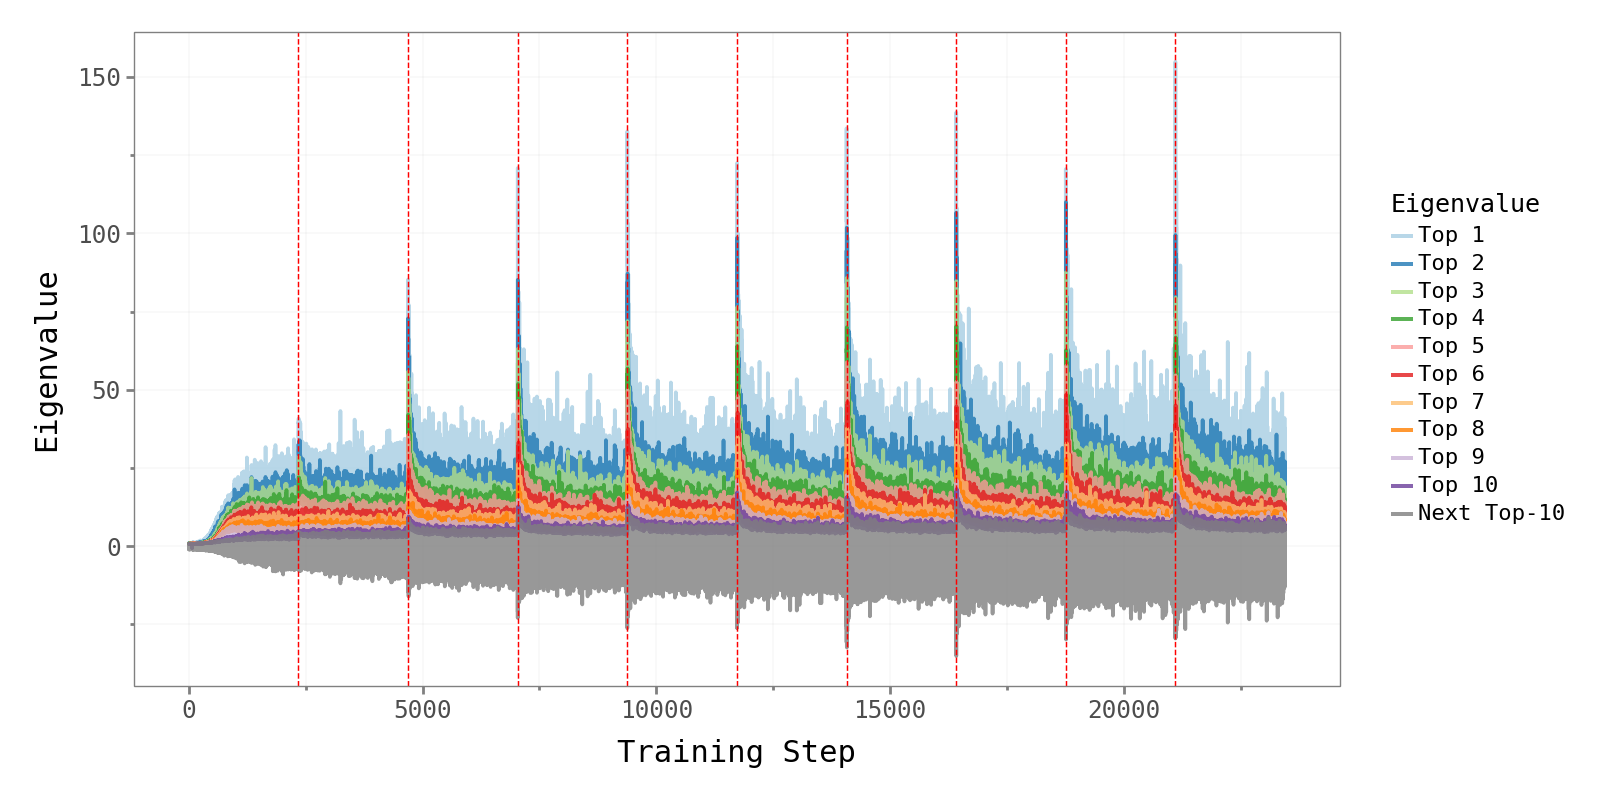

In [3]:
plot_topk_next_topk_eigenvalues(pmnist_main_dict['None']['eigenvalues'], 10, PMNIST_BOUNDARIES)

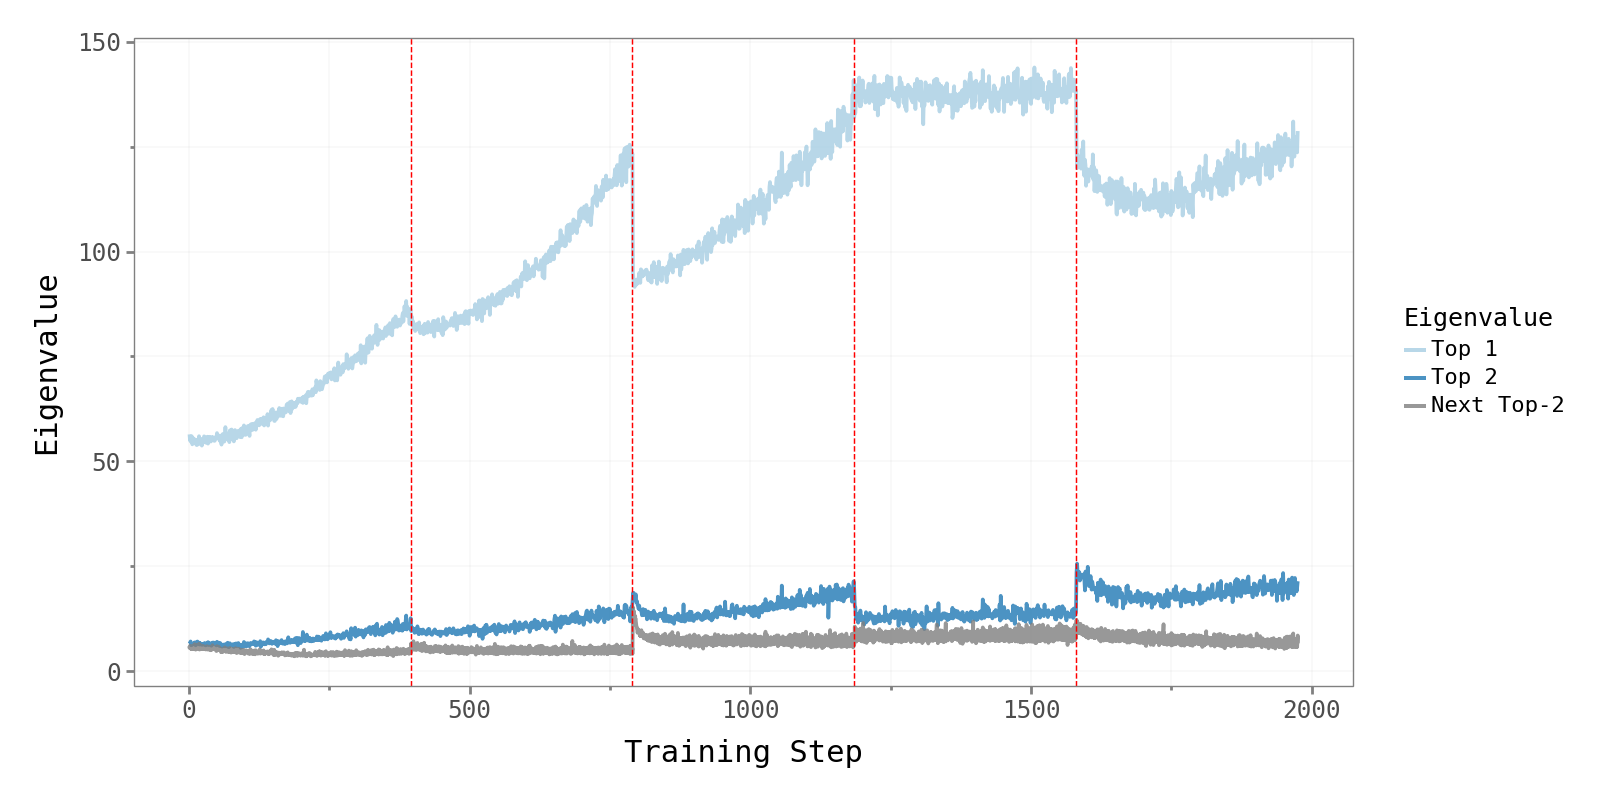

In [4]:
plot_topk_next_topk_eigenvalues(cifar10_main_dict['None']['eigenvalues'], 2, CIFAR10_BOUNDARIES)

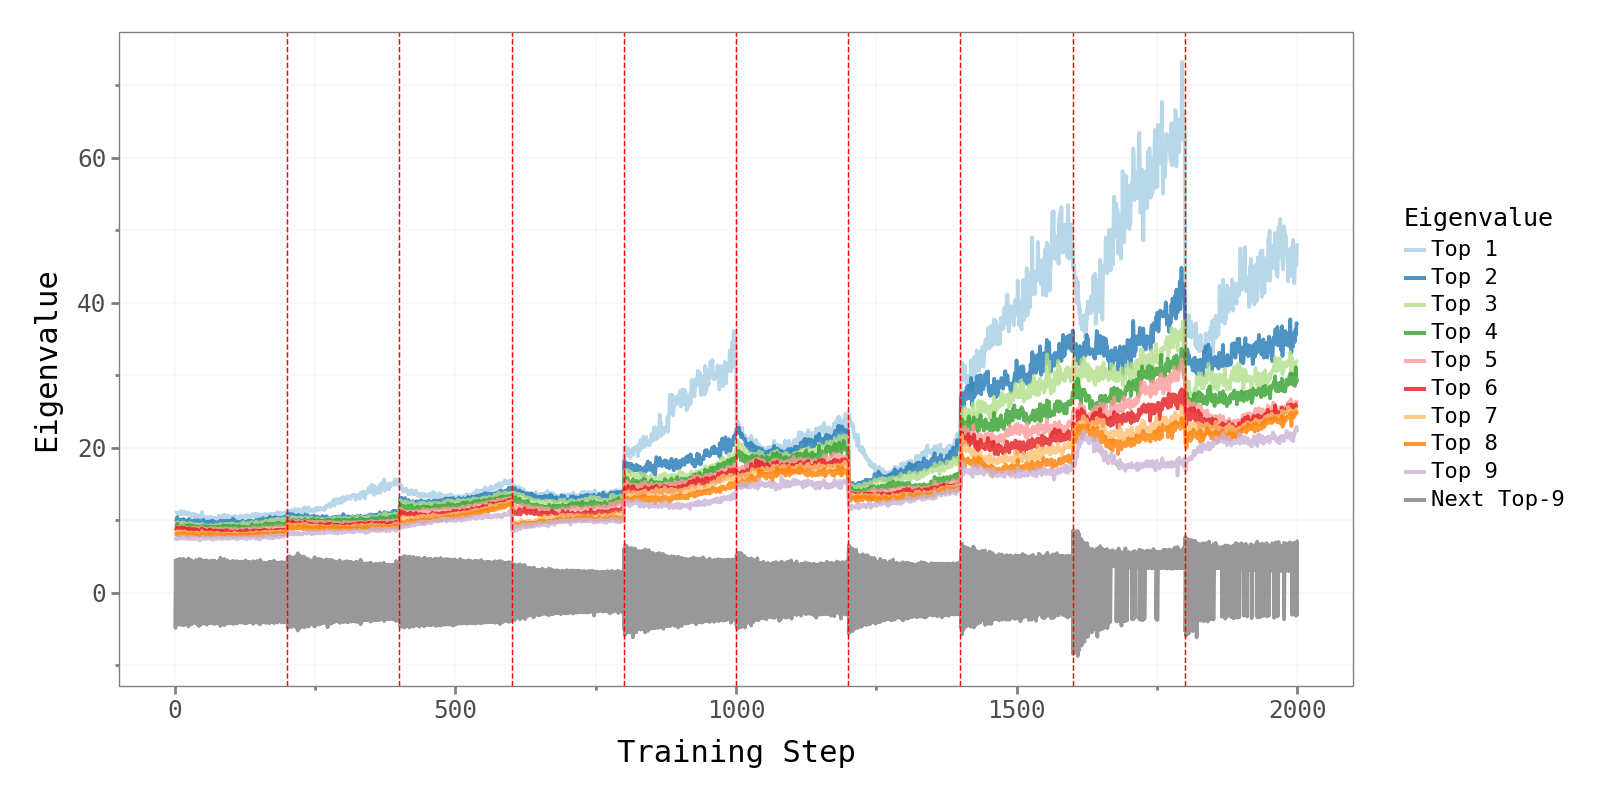

In [5]:
plot_topk_next_topk_eigenvalues(cifar100_main_dict['None']['eigenvalues'], 9, CIFAR100_BOUNDARIES)

#### Top-K Overlap for SGD

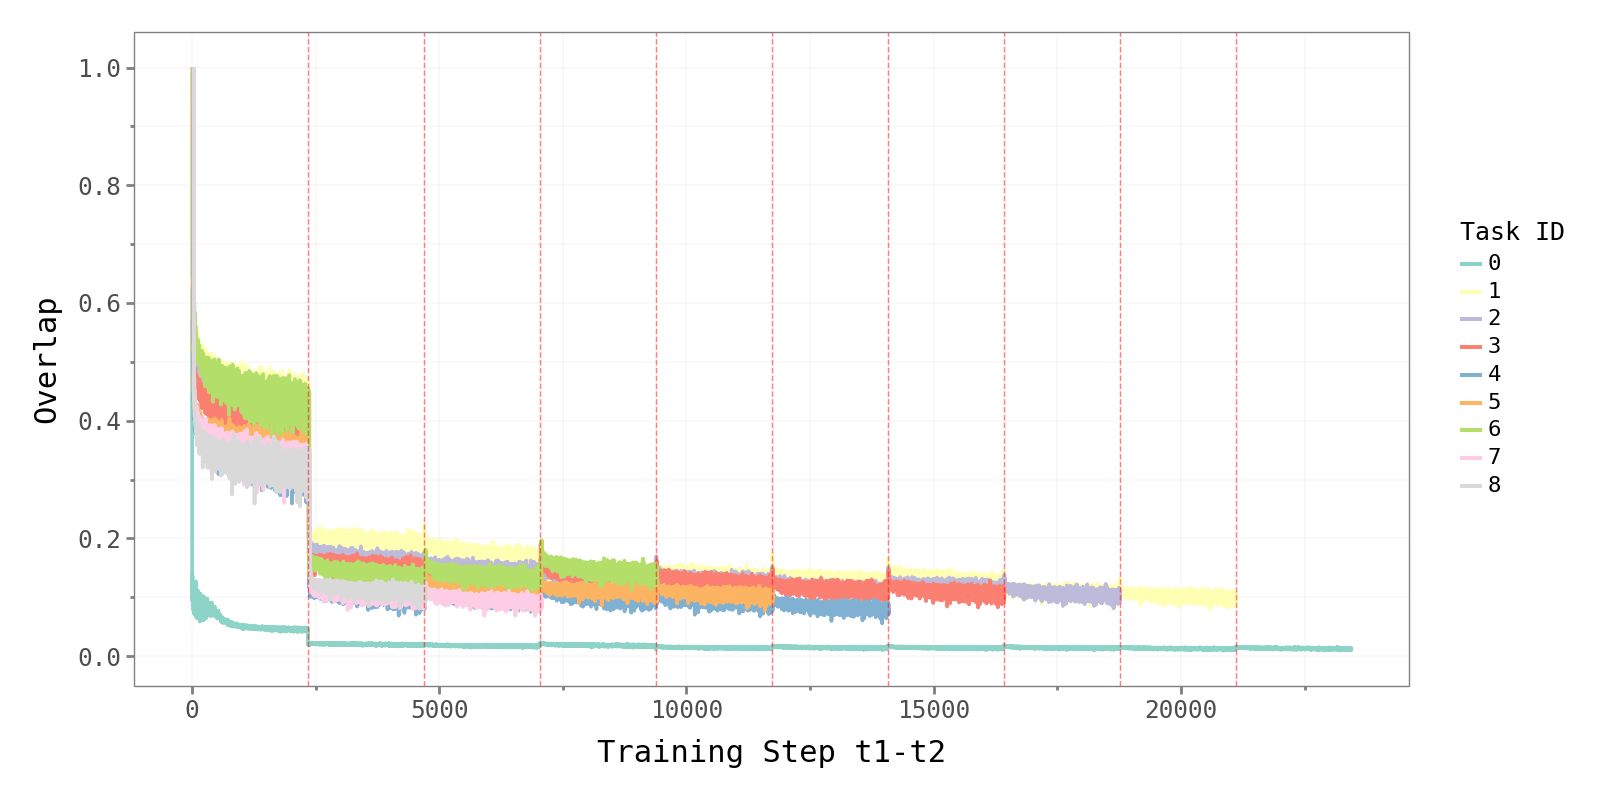

In [8]:
topk_overlap(pmnist_main_dict['None']['overlaps'], PMNIST_BOUNDARIES, "dominant", 10)

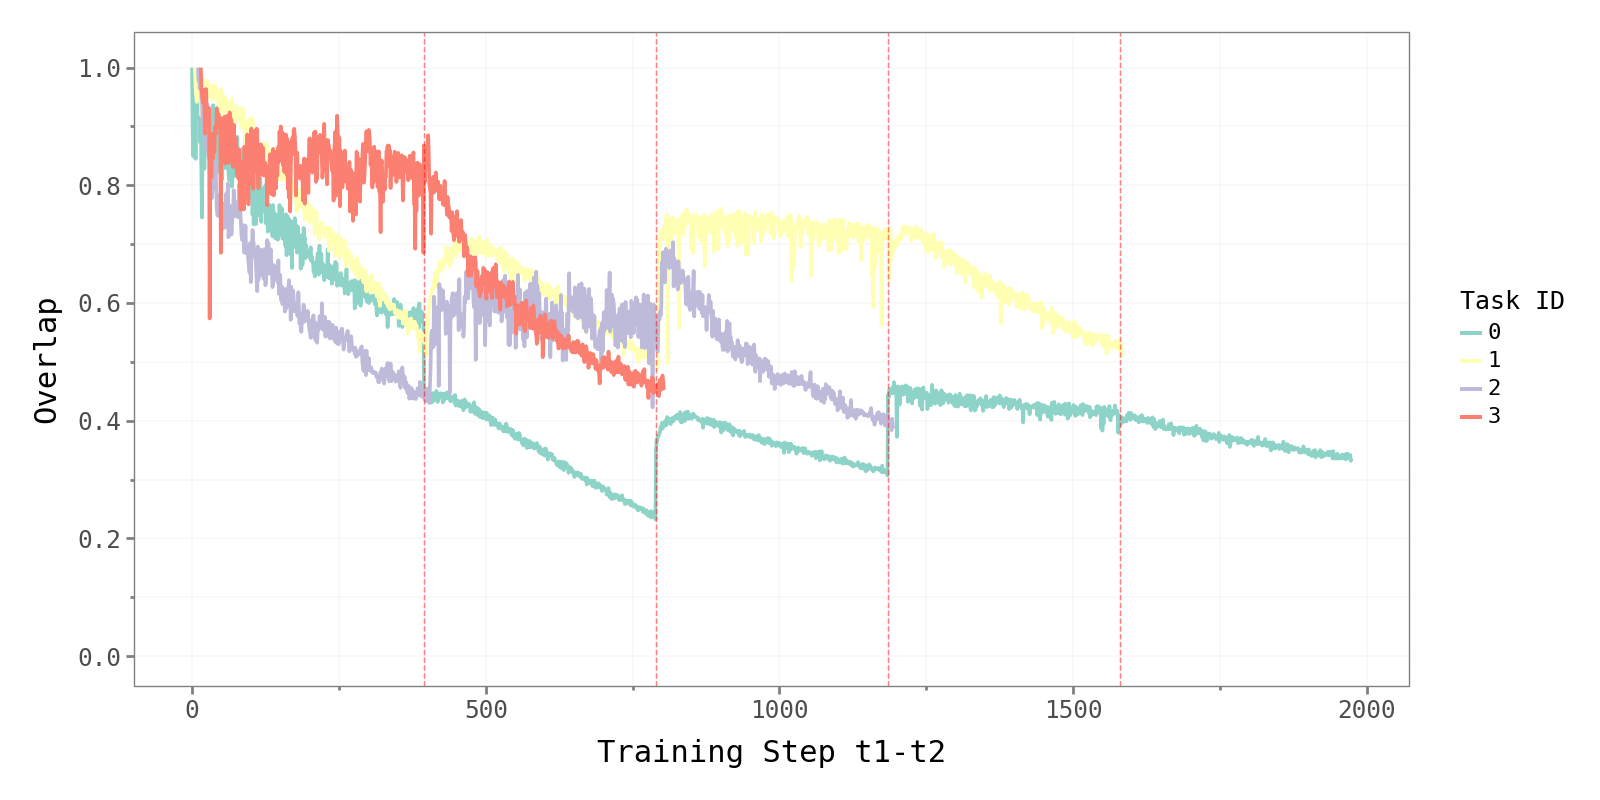

In [9]:
topk_overlap(cifar10_main_dict['None']['overlaps'], CIFAR10_BOUNDARIES, "dominant", 2)

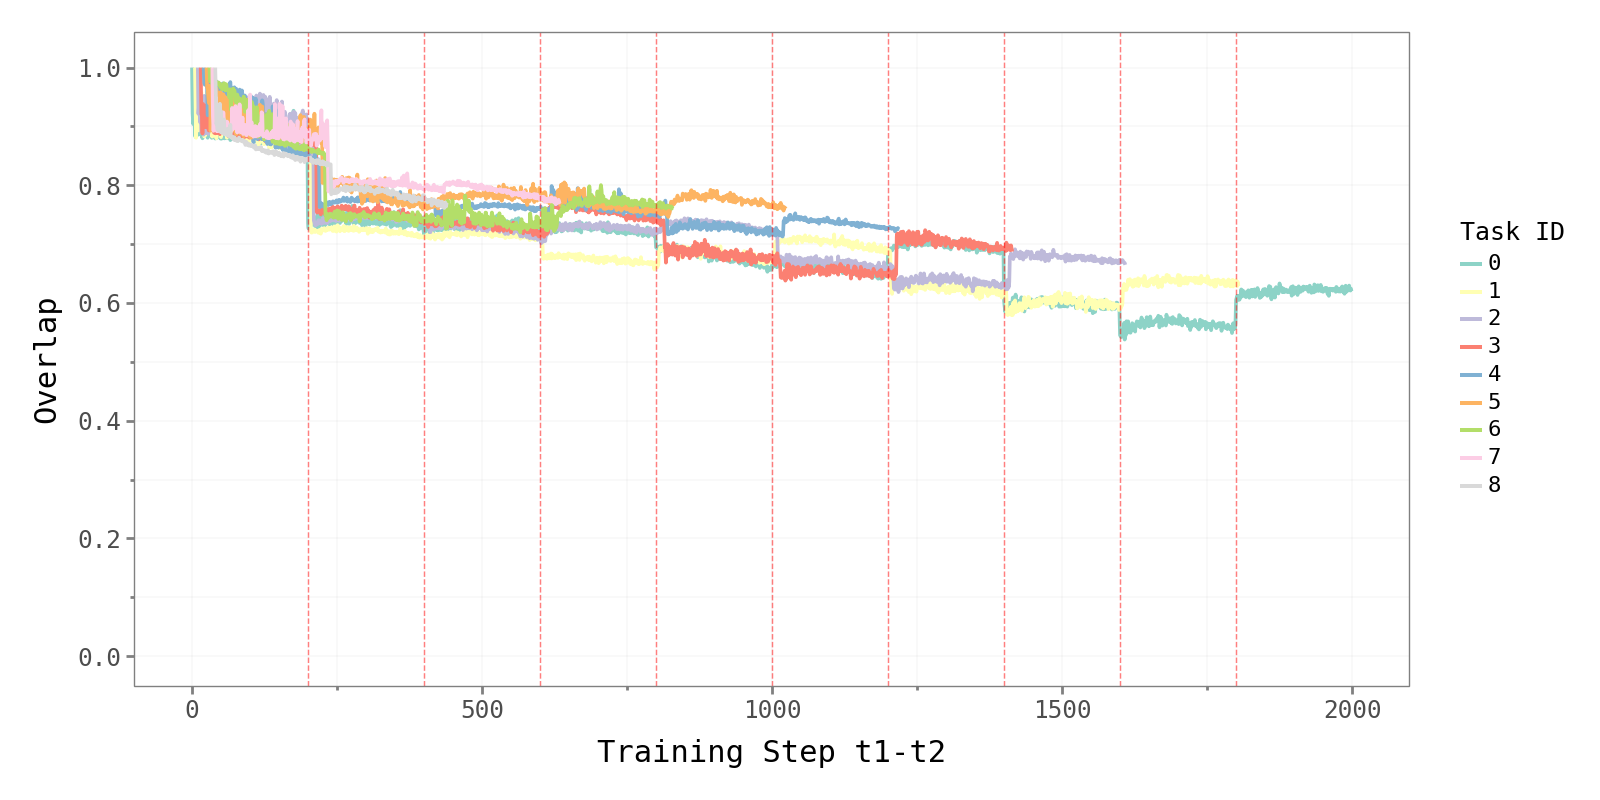

In [10]:
topk_overlap(cifar100_main_dict['None']['overlaps'], CIFAR100_BOUNDARIES, "dominant", 9)

#### Max Eigenvalue over Time for SGD versus SGD-DOM versus SGD-BULK

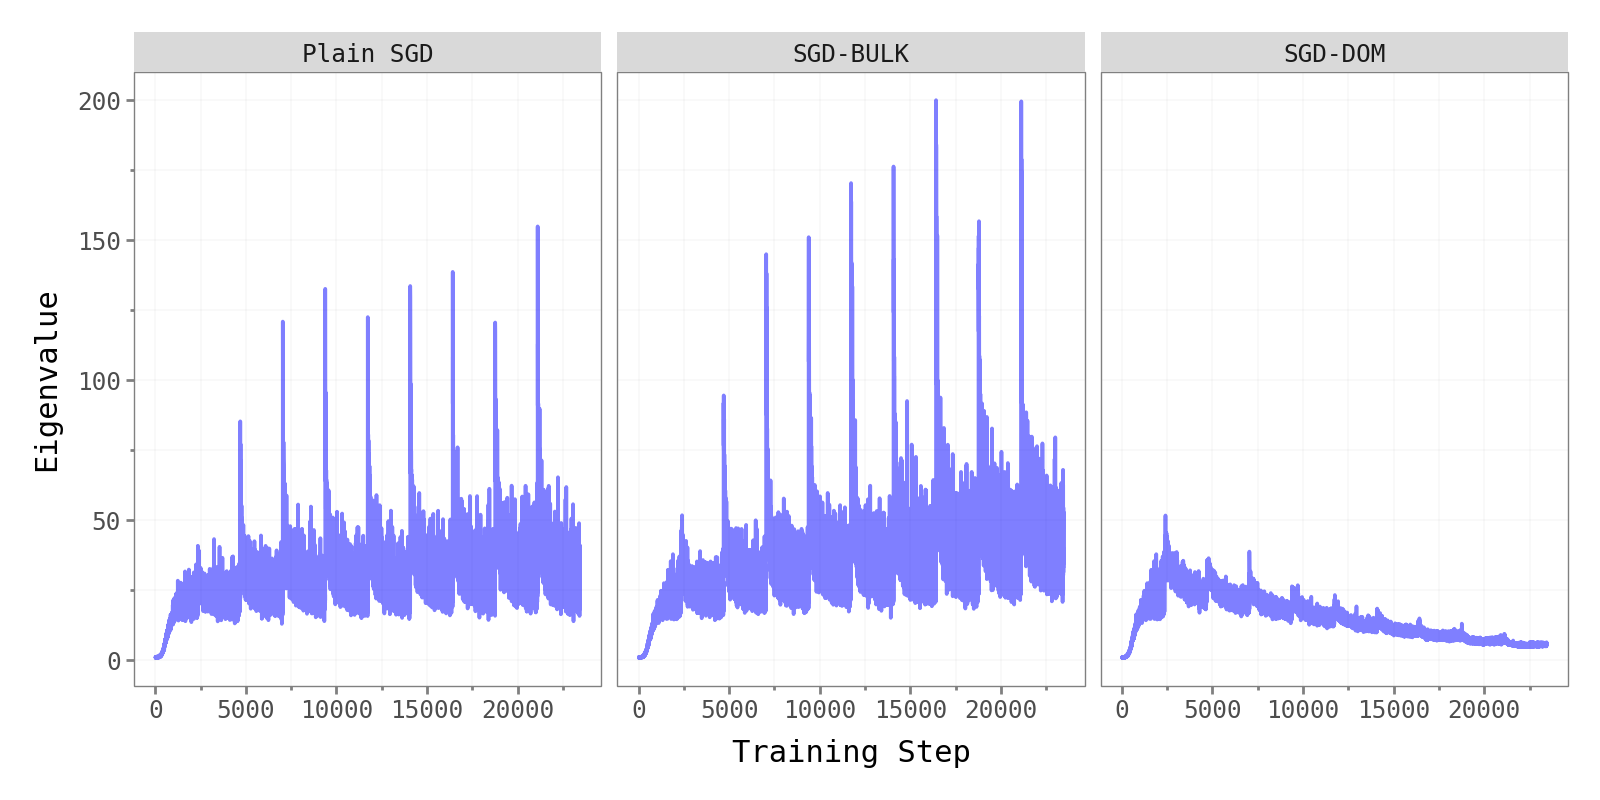

In [11]:
plot_max_eigenvalues_dom_bulk_plain(eigenvalues = pd.concat([pmnist_main_dict[space]['eigenvalues'] for space in SUBSPACE_TYPES]))

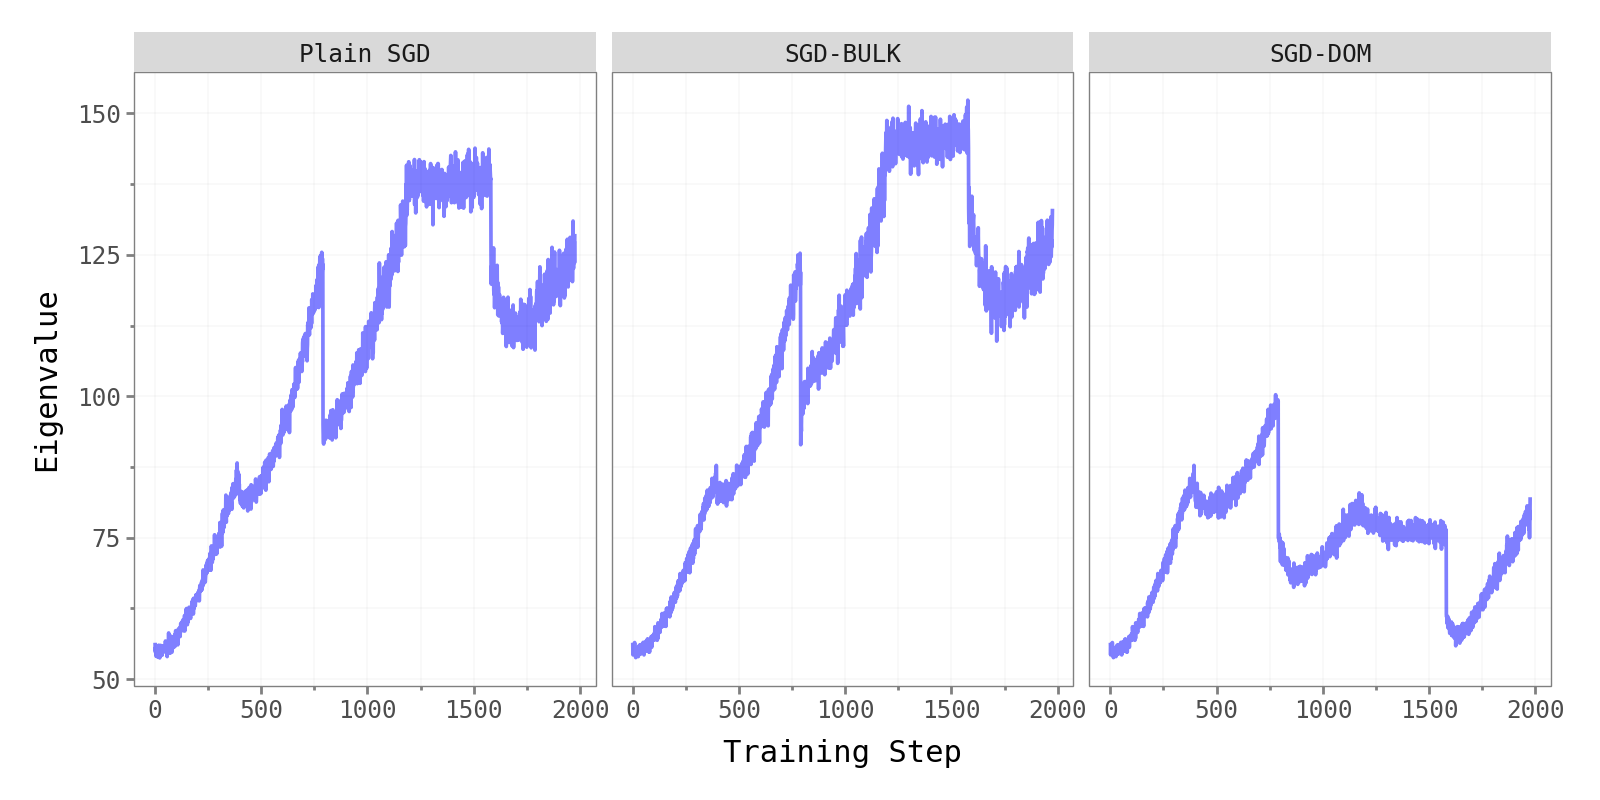

In [12]:
plot_max_eigenvalues_dom_bulk_plain(eigenvalues = pd.concat([cifar10_main_dict[space]['eigenvalues'] for space in SUBSPACE_TYPES]))

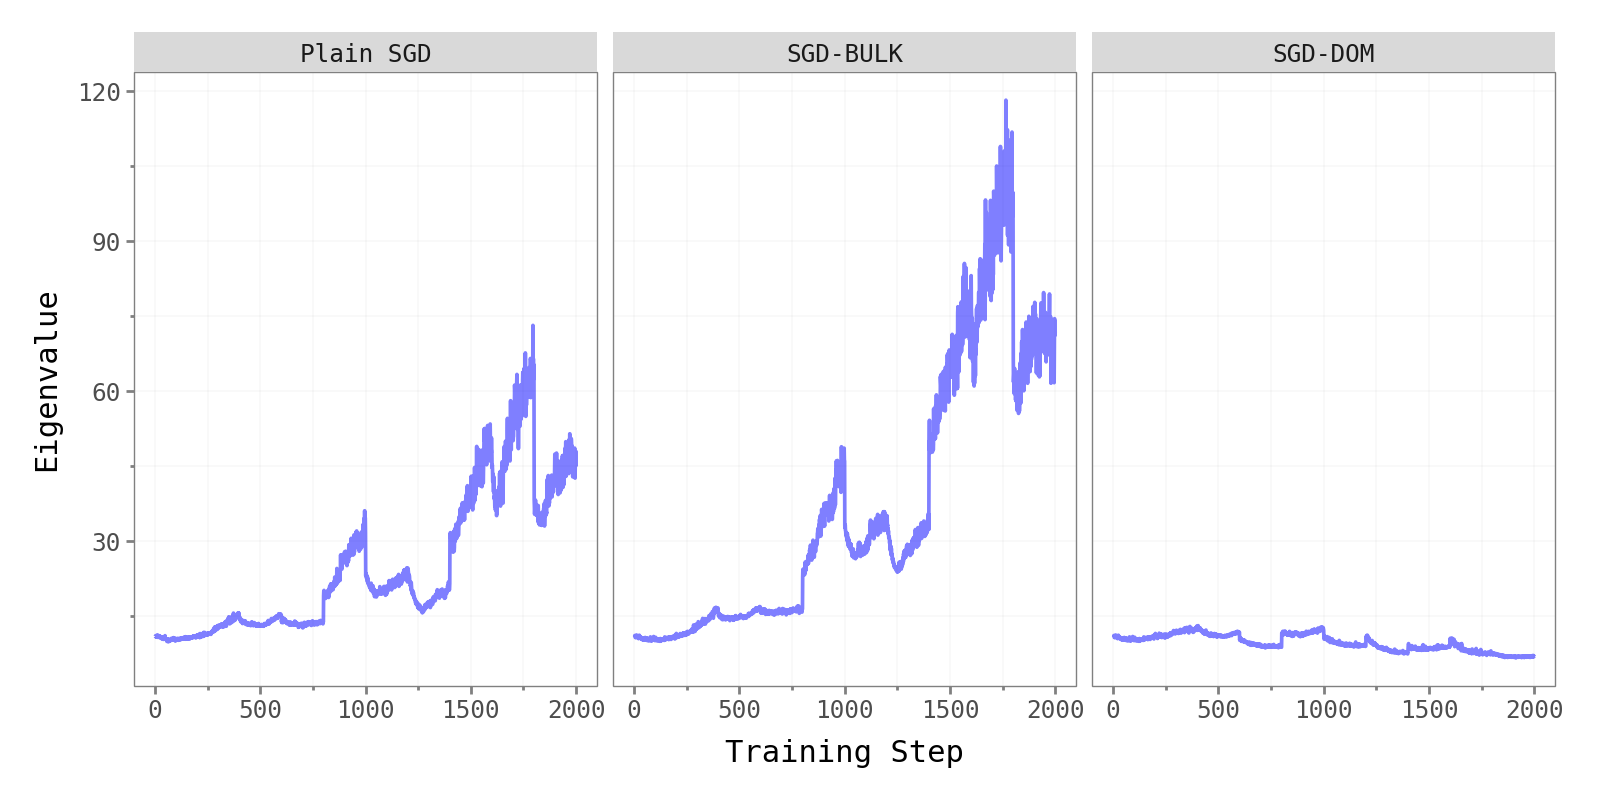

In [13]:
plot_max_eigenvalues_dom_bulk_plain(eigenvalues = pd.concat([cifar100_main_dict[space]['eigenvalues'] for space in SUBSPACE_TYPES]))

#### Training Metrics over Time for SGD versus SGD-DOM versus SGD-BULK

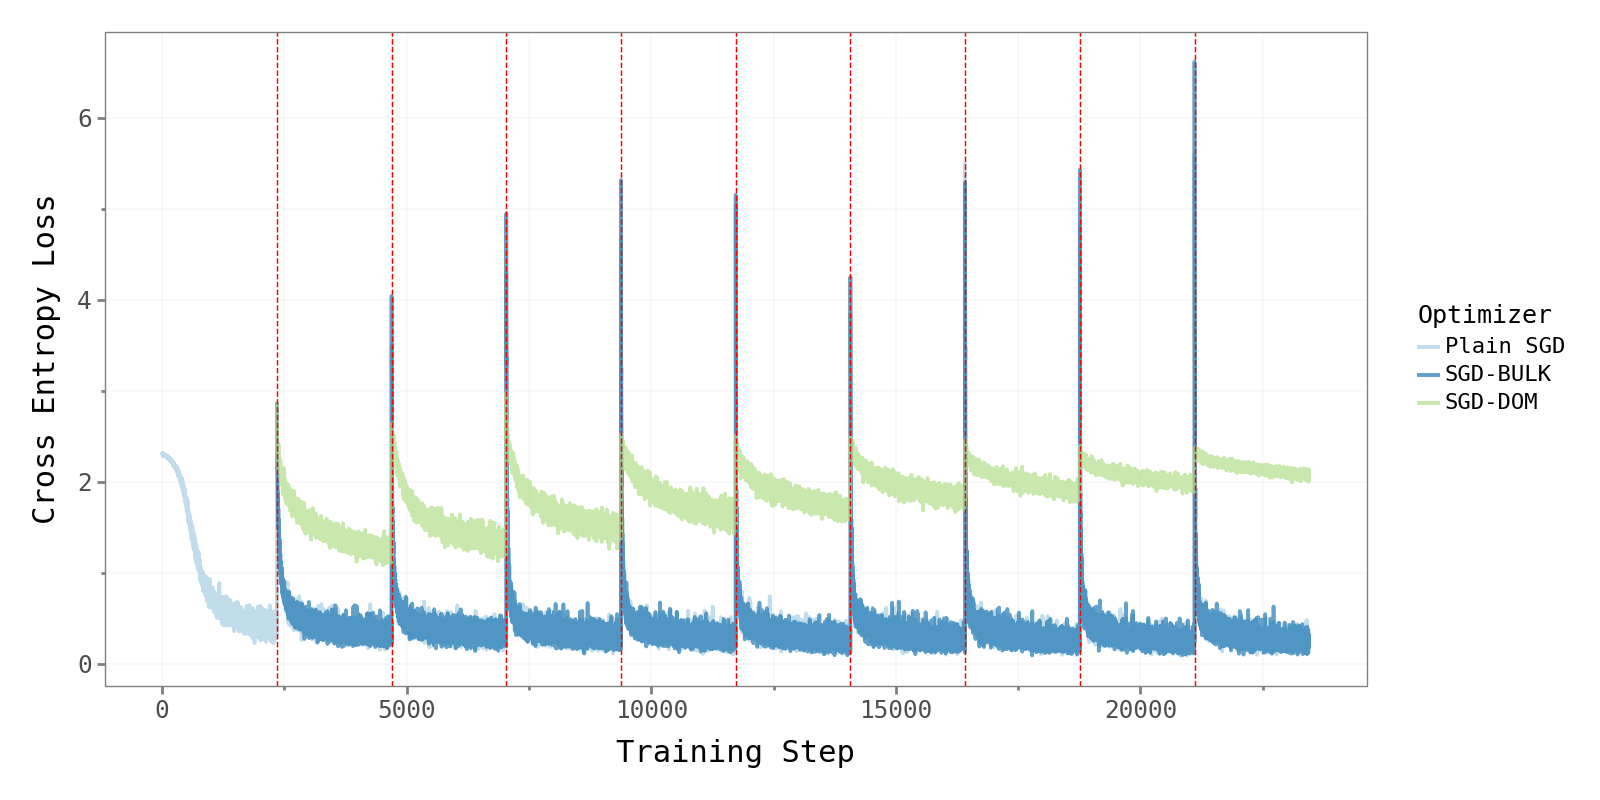

In [14]:
plot_train_metric(pd.concat([pmnist_main_dict[space]['train_metrics'] for space in SUBSPACE_TYPES]), PMNIST_BOUNDARIES)

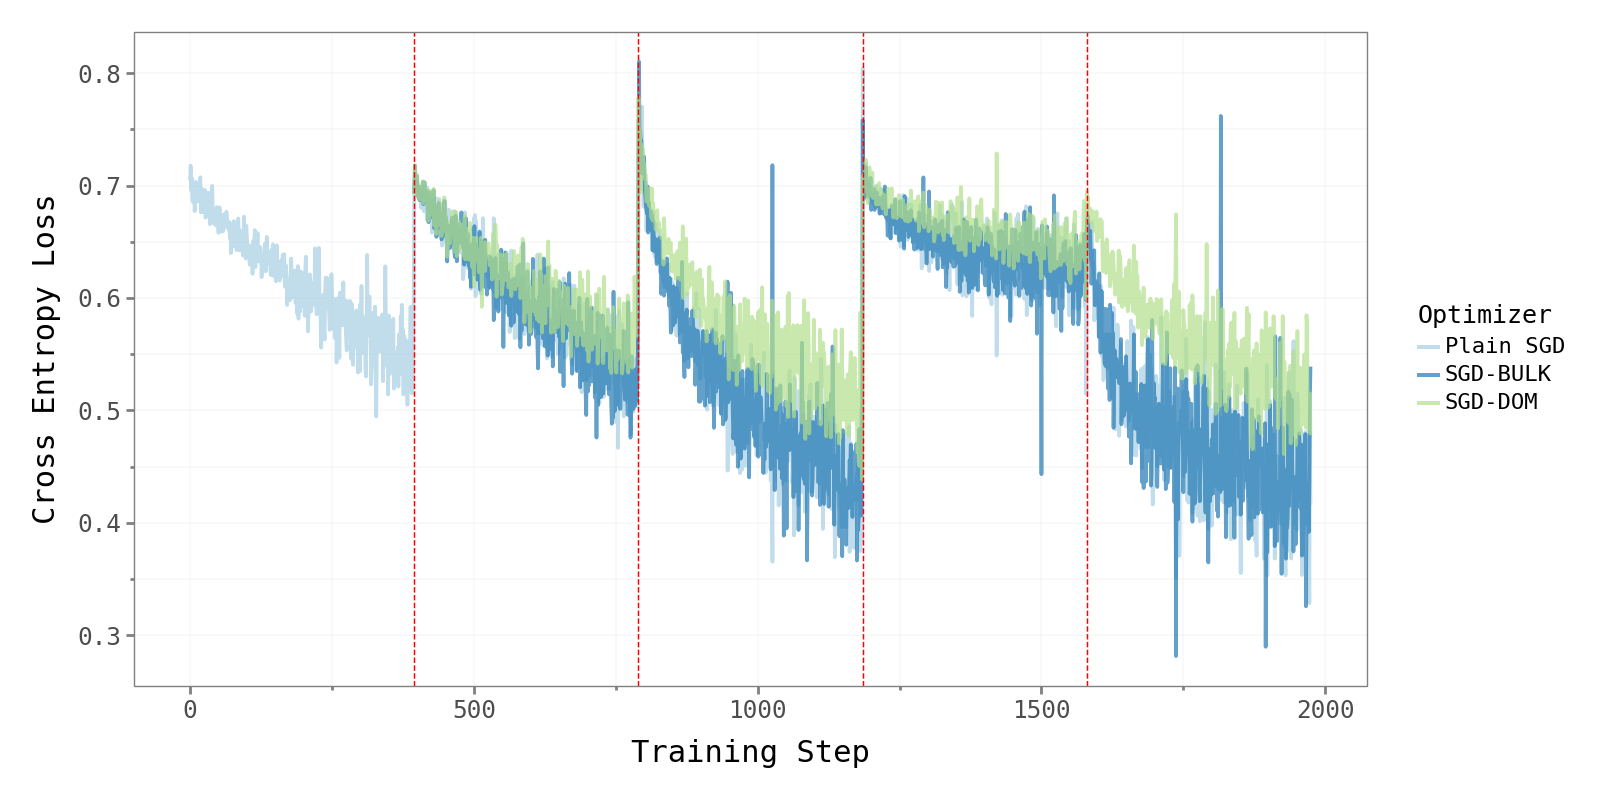

In [15]:
plot_train_metric(pd.concat([cifar10_main_dict[space]['train_metrics'] for space in SUBSPACE_TYPES]), CIFAR10_BOUNDARIES)

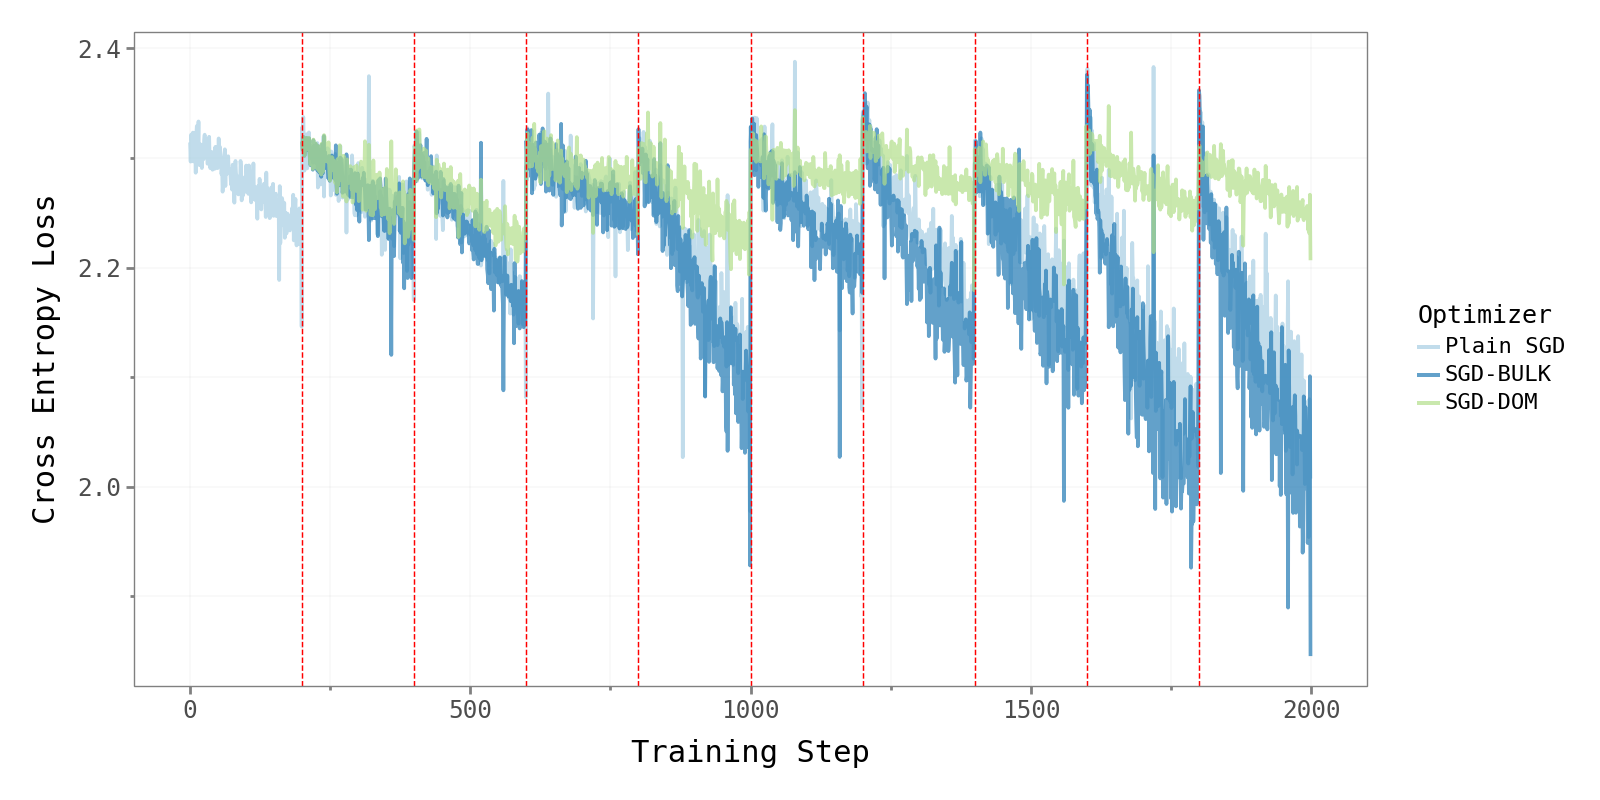

In [16]:
plot_train_metric(pd.concat([cifar100_main_dict[space]['train_metrics'] for space in SUBSPACE_TYPES]), CIFAR100_BOUNDARIES)

#### Test Metrics over Time for SGD versus SGD-DOM versus SGD-BULK

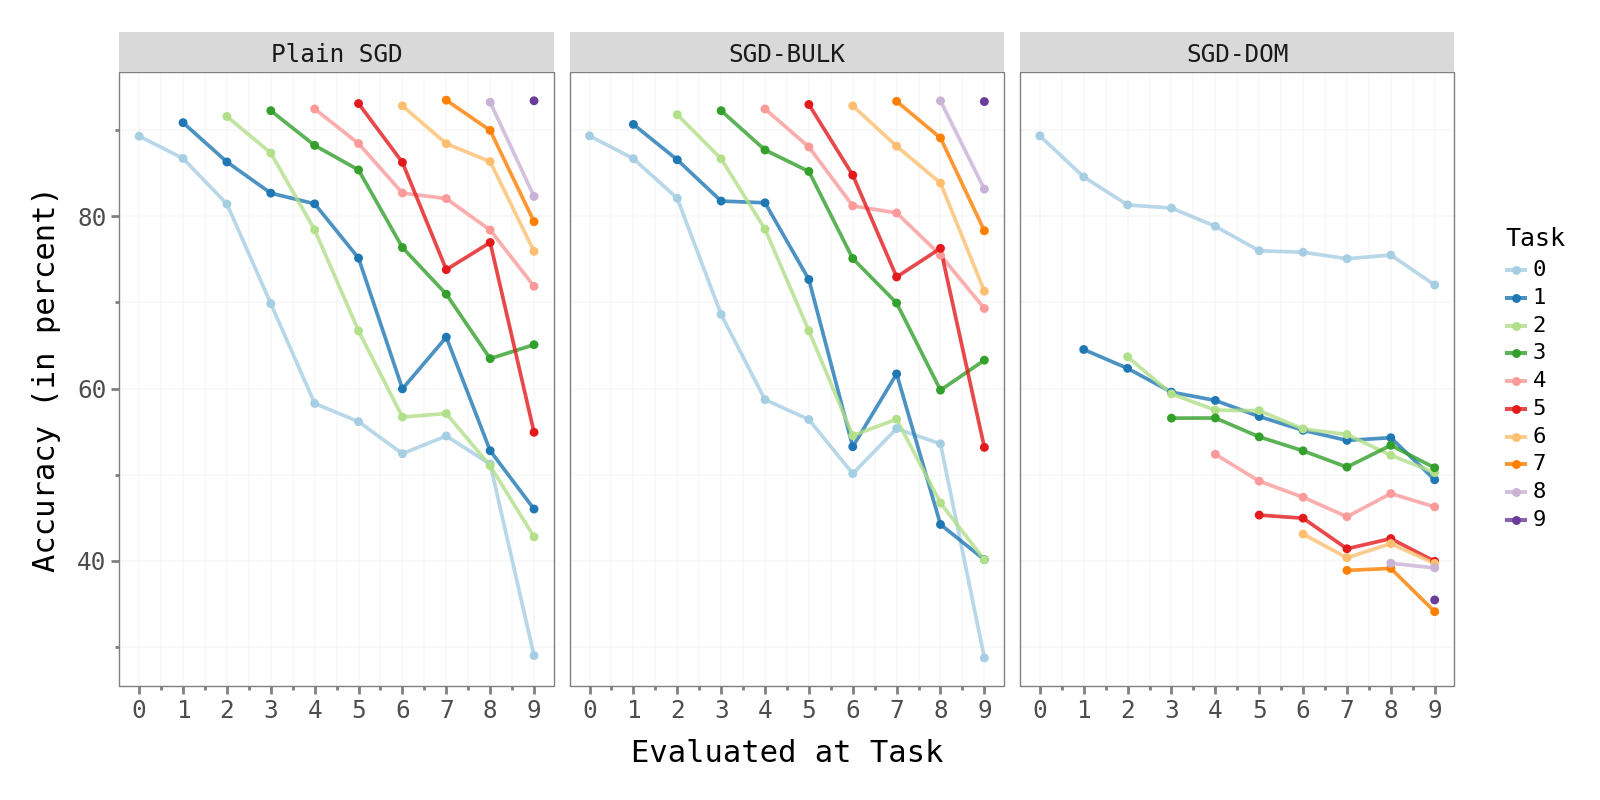

In [17]:
plot_test_metric(pd.concat([pmnist_main_dict[space]['test_metrics'] for space in SUBSPACE_TYPES]))

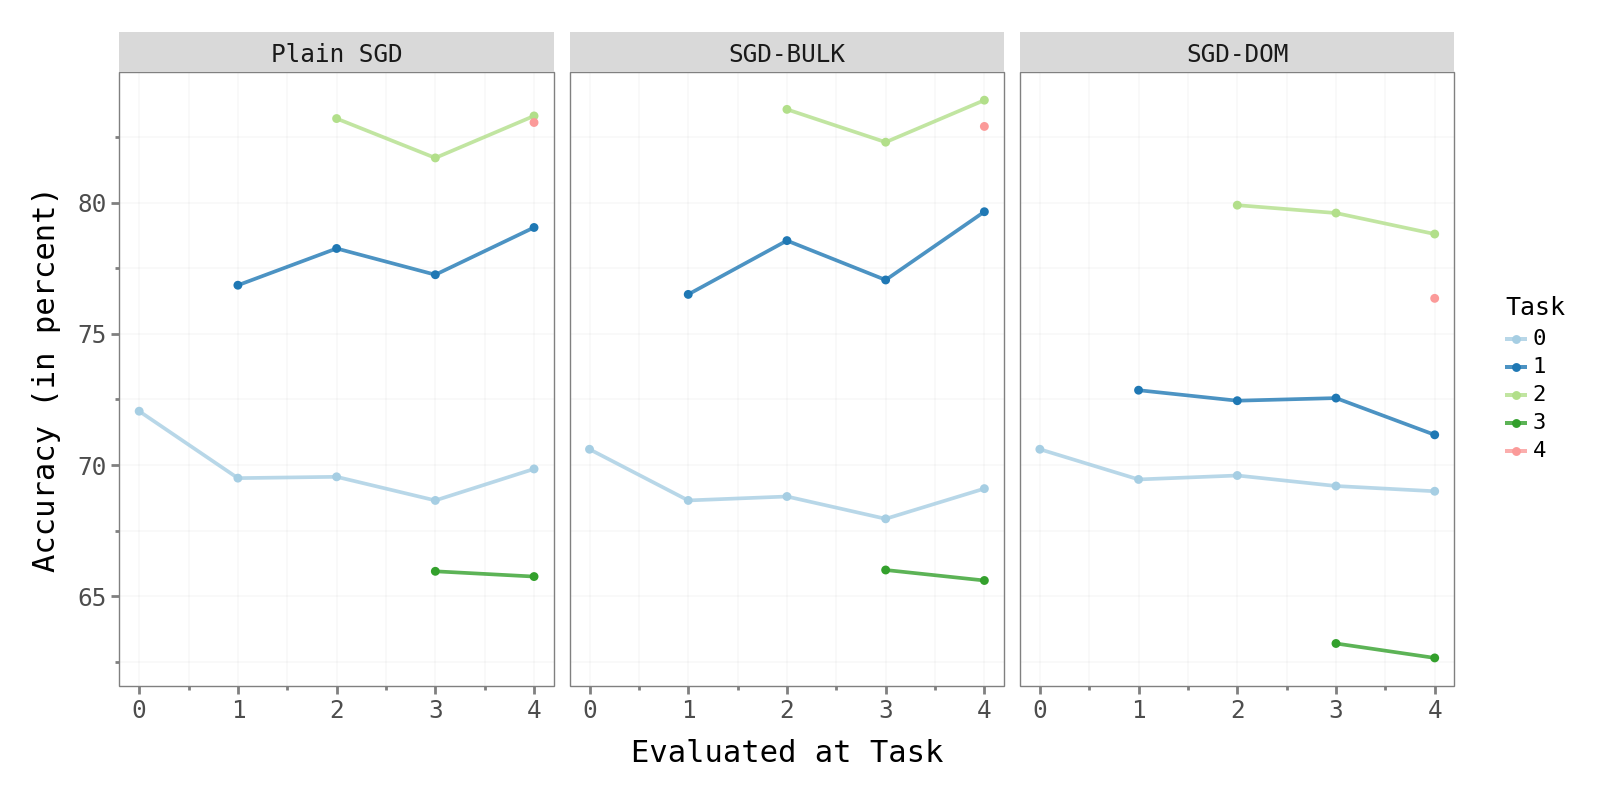

In [18]:
plot_test_metric(pd.concat([cifar10_main_dict[space]['test_metrics'] for space in SUBSPACE_TYPES]))

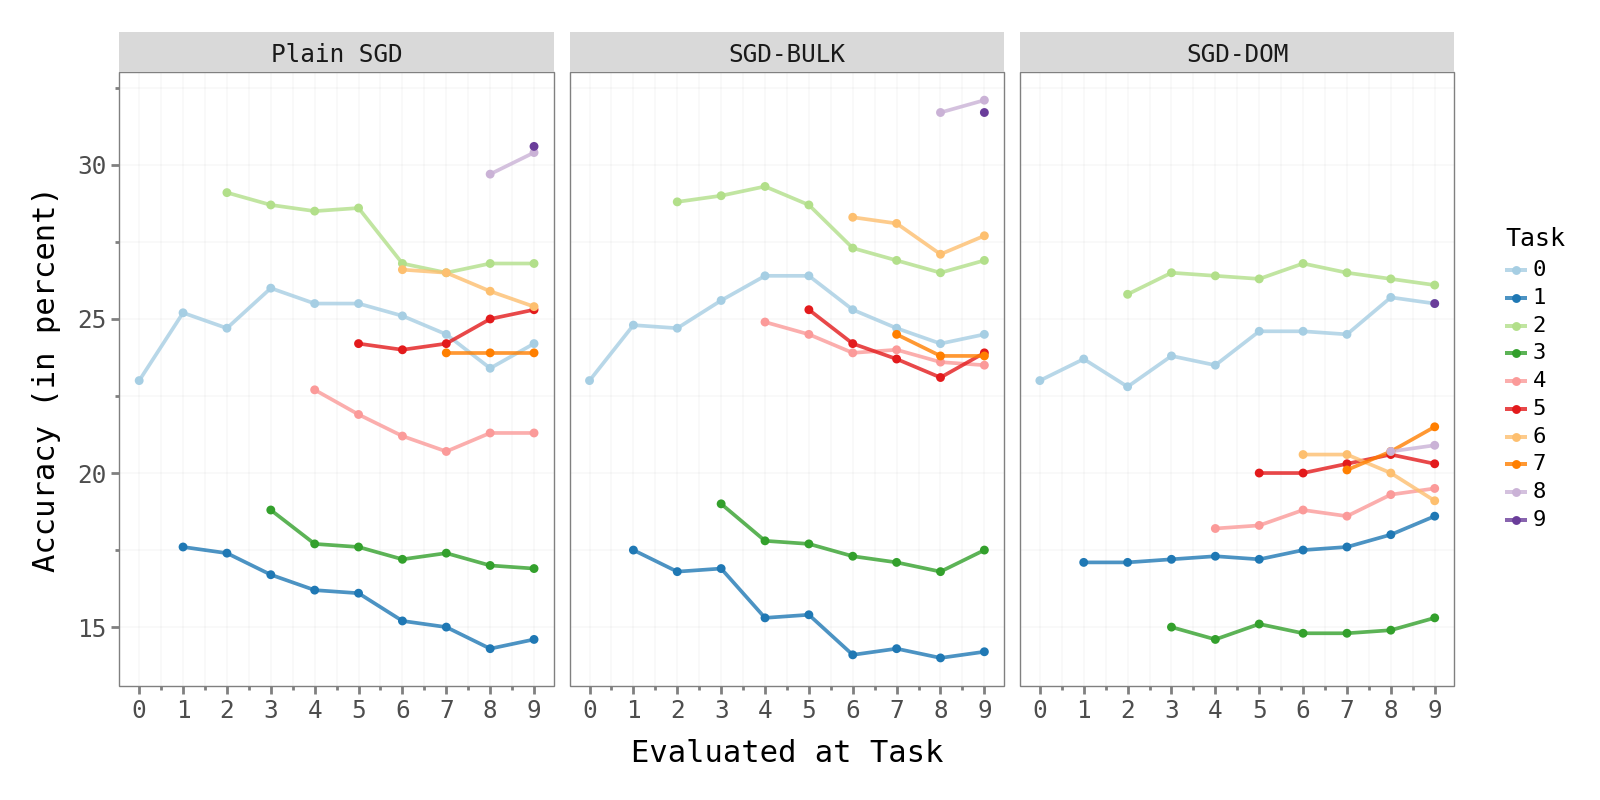

In [19]:
plot_test_metric(pd.concat([cifar100_main_dict[space]['test_metrics'] for space in SUBSPACE_TYPES]))

#### Eigenvalues over Time for SGD-BULK (Ablation)

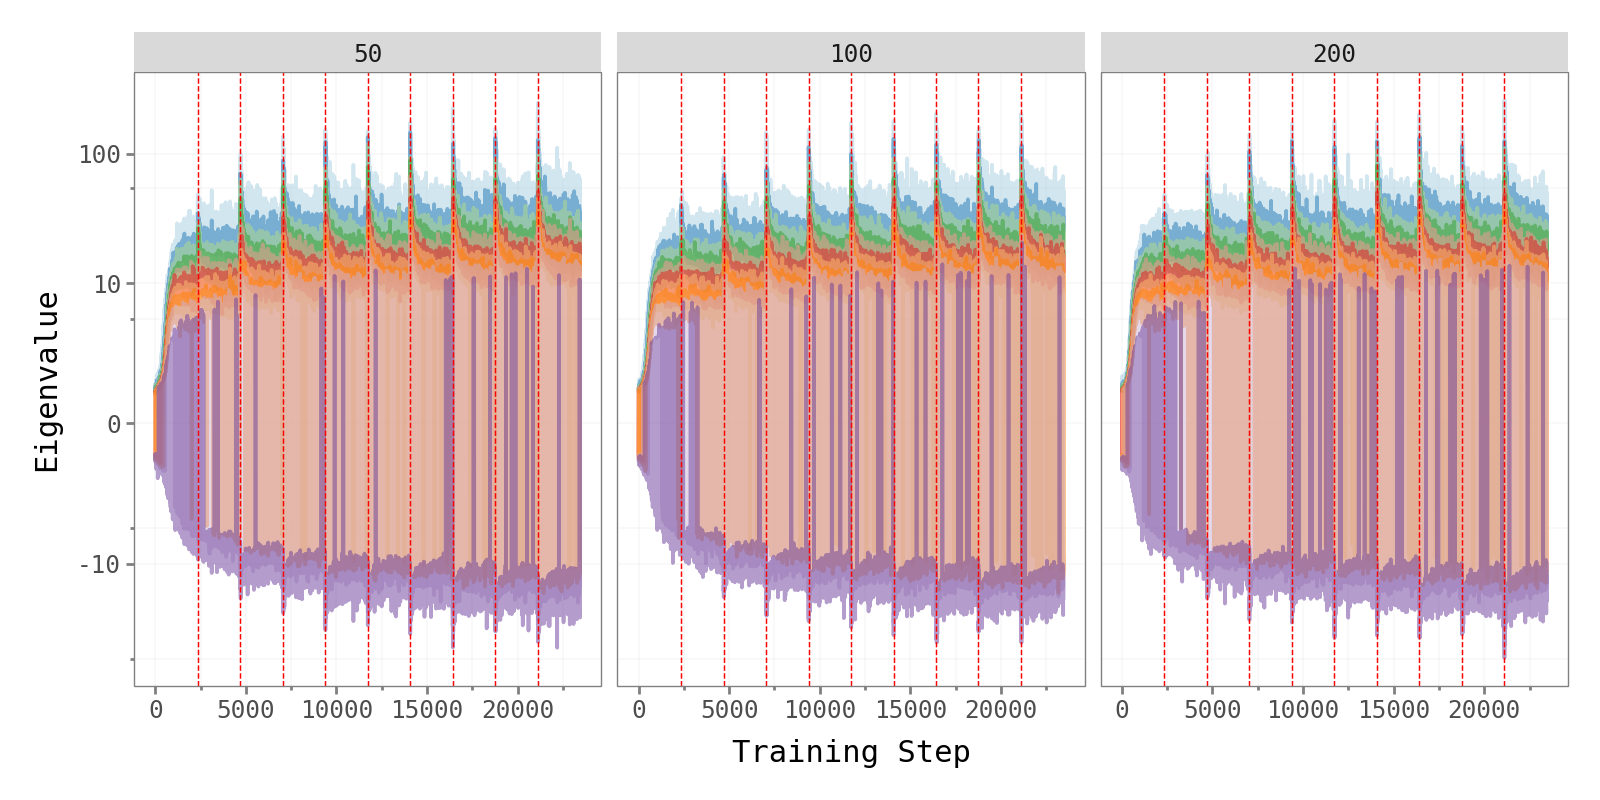

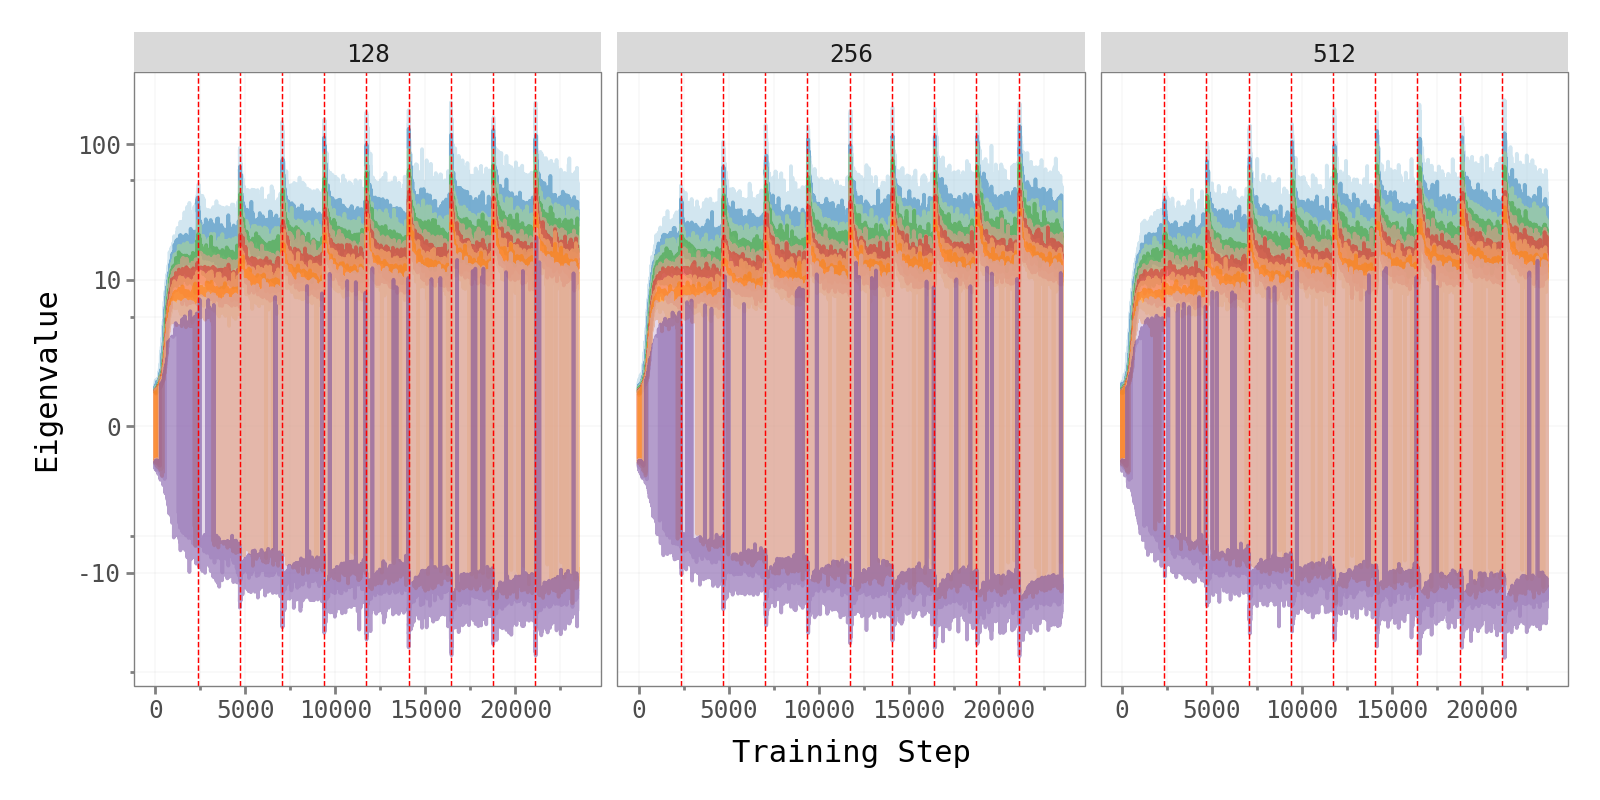

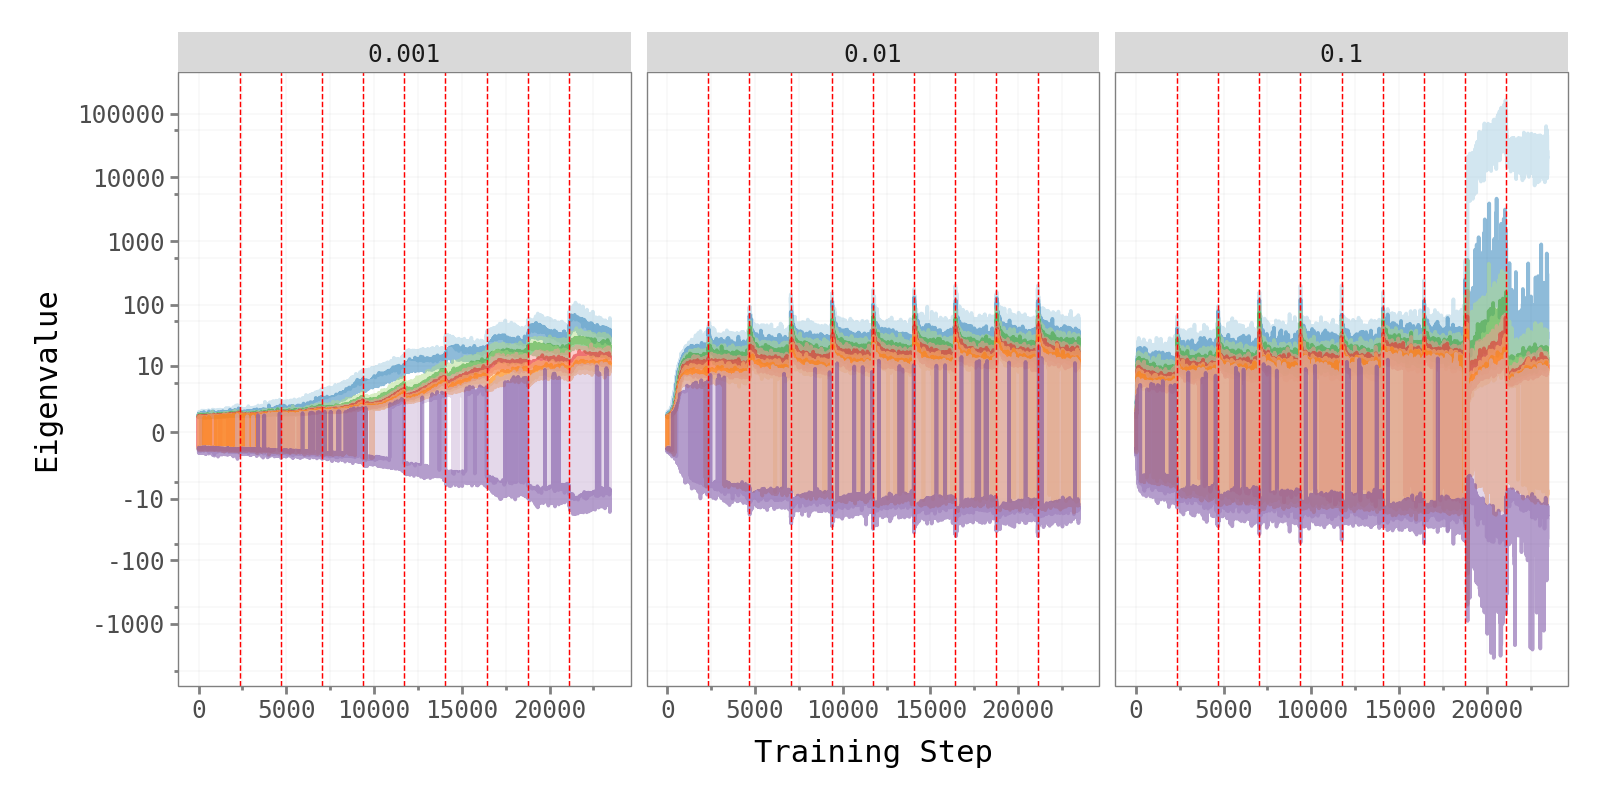

In [34]:
pmnist_eigenvalues_sgd = pmnist_main_dict['bulk']['eigenvalues']
pmnist_eigenvalues_sgd = pmnist_eigenvalues_sgd[pmnist_eigenvalues_sgd['eigenvalue_nr'].between(1, 10)]

for ab in pmnist_ablation_dict.keys():

    temp = pd.concat(pmnist_ablation_dict[ab]['eigenvalues'].values(), ignore_index=True)
    
    fig = (
        pn.ggplot(
            pd.concat([pmnist_eigenvalues_sgd, temp], ignore_index=True),
            pn.aes(
                x="step",
                y="value",
                color="factor(eigenvalue_nr)",
                group="eigenvalue_nr",
            ),
        )
        + pn.geom_line(size=0.75, alpha=0.5)
        + pn.scale_color_brewer(type="qual", palette="Paired")
        + scale_y_continuous(trans='symlog')
        + pn.geom_vline(
            xintercept=PMNIST_BOUNDARIES, color="red", linetype="dashed", size=0.3
        )
        + pn.facet_wrap(f"~{ab}")
        + THEME_ACADEMIC
        + pn.theme(legend_position="none")
        + pn.labs(
            x="Training Step",
            y="Eigenvalue",
        )
    )

    display(fig)


#### Appendix: Overlap over Time (Ablation)

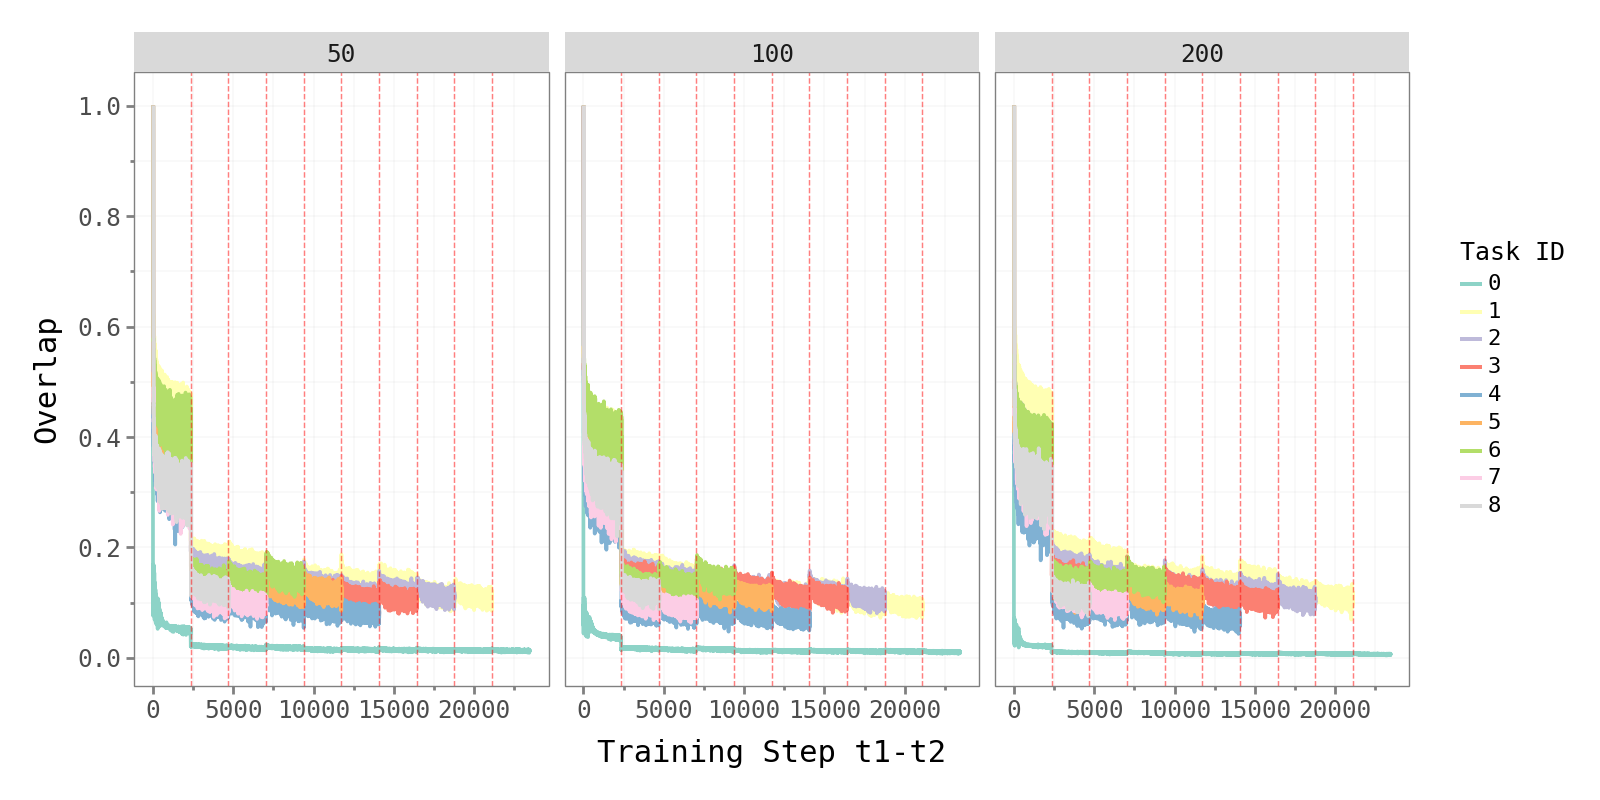

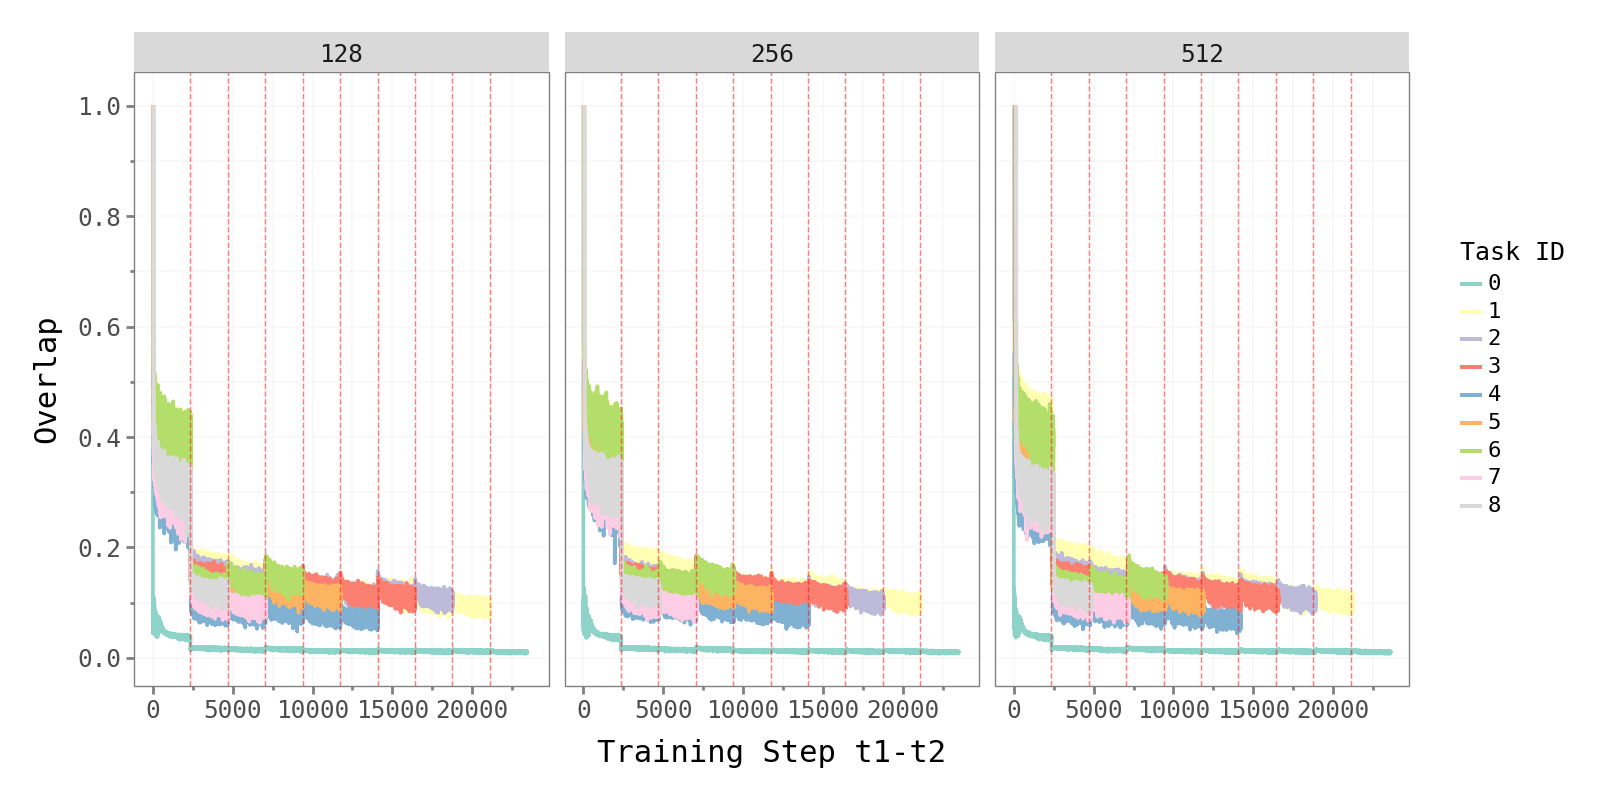

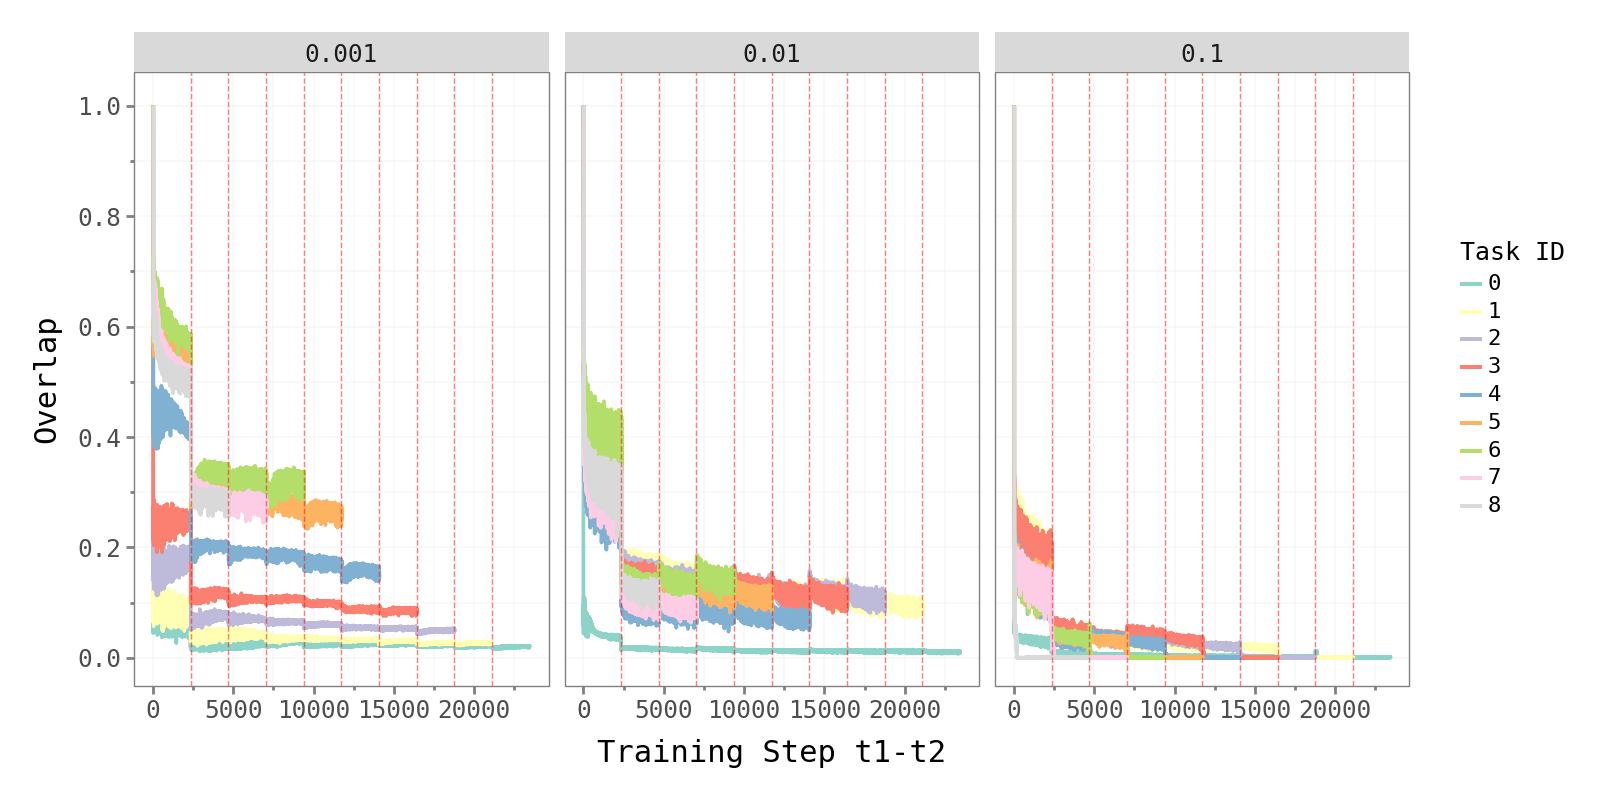

In [21]:
overlap_ablation(pmnist_main_dict['bulk']['overlaps'], pmnist_ablation_dict, PMNIST_BOUNDARIES, "dominant", 10)

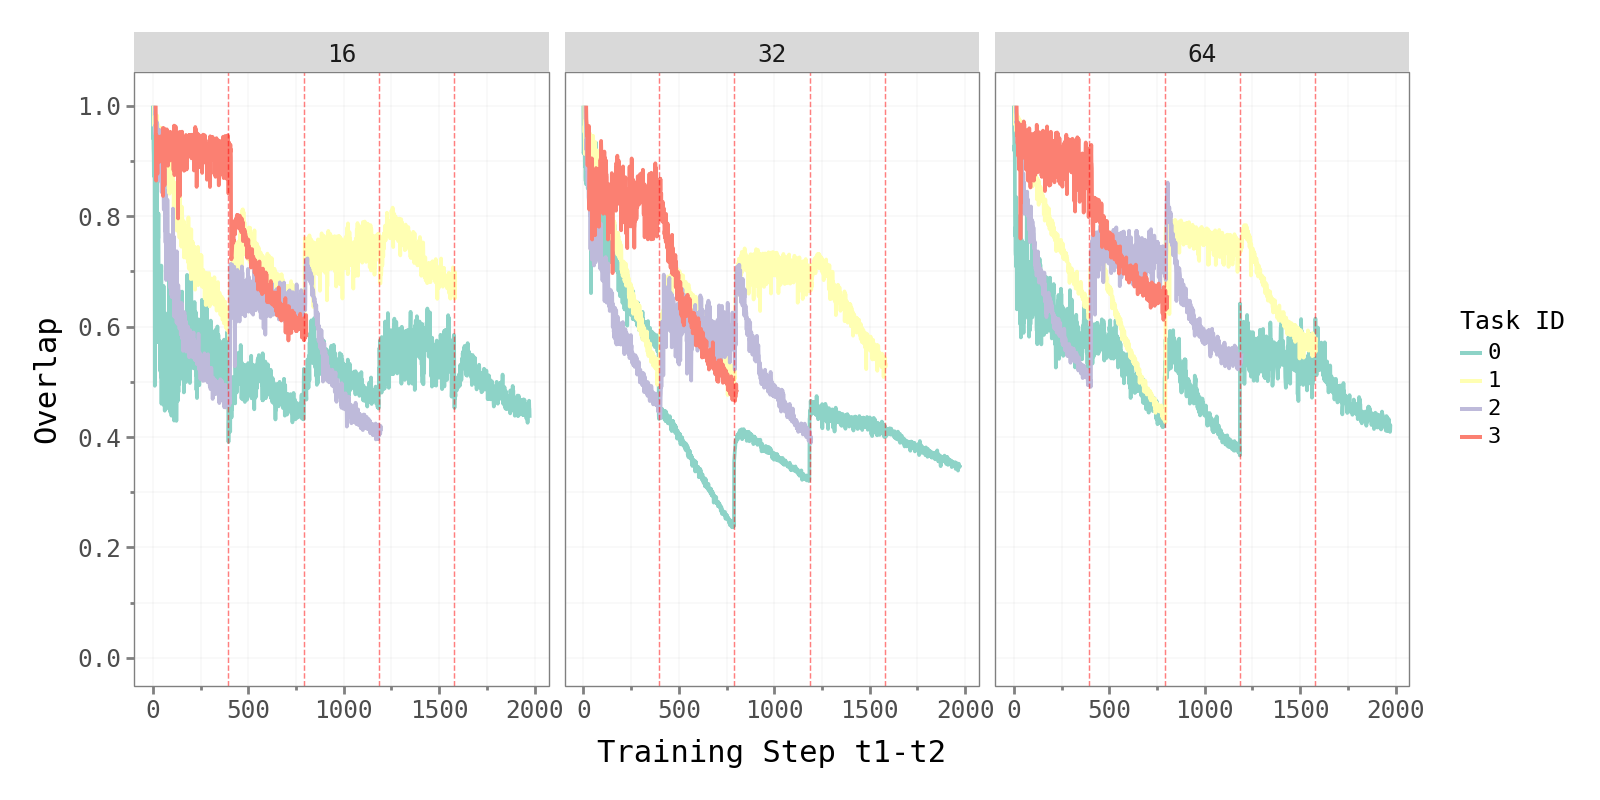

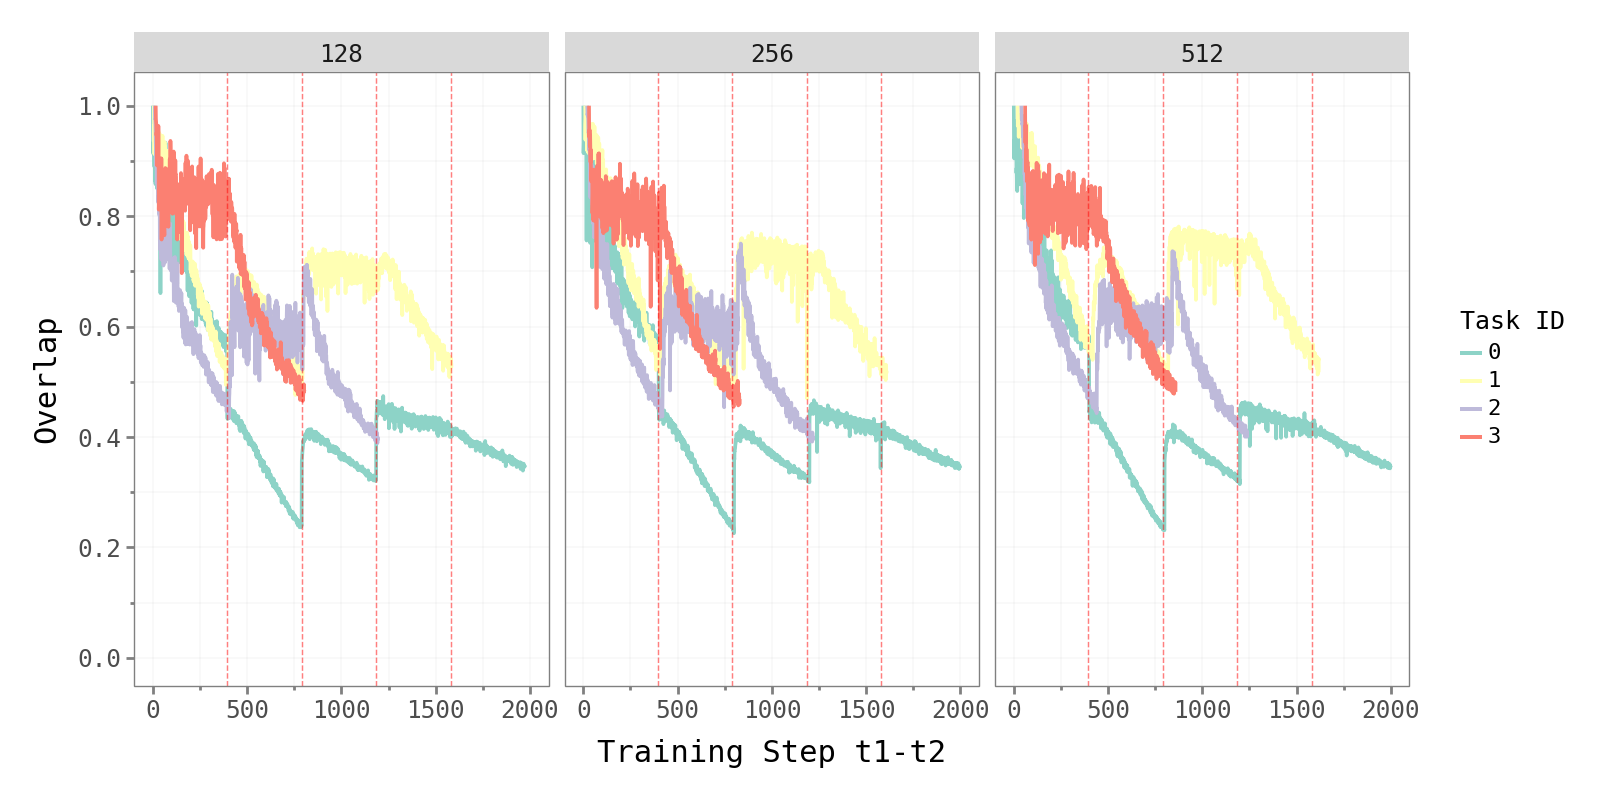

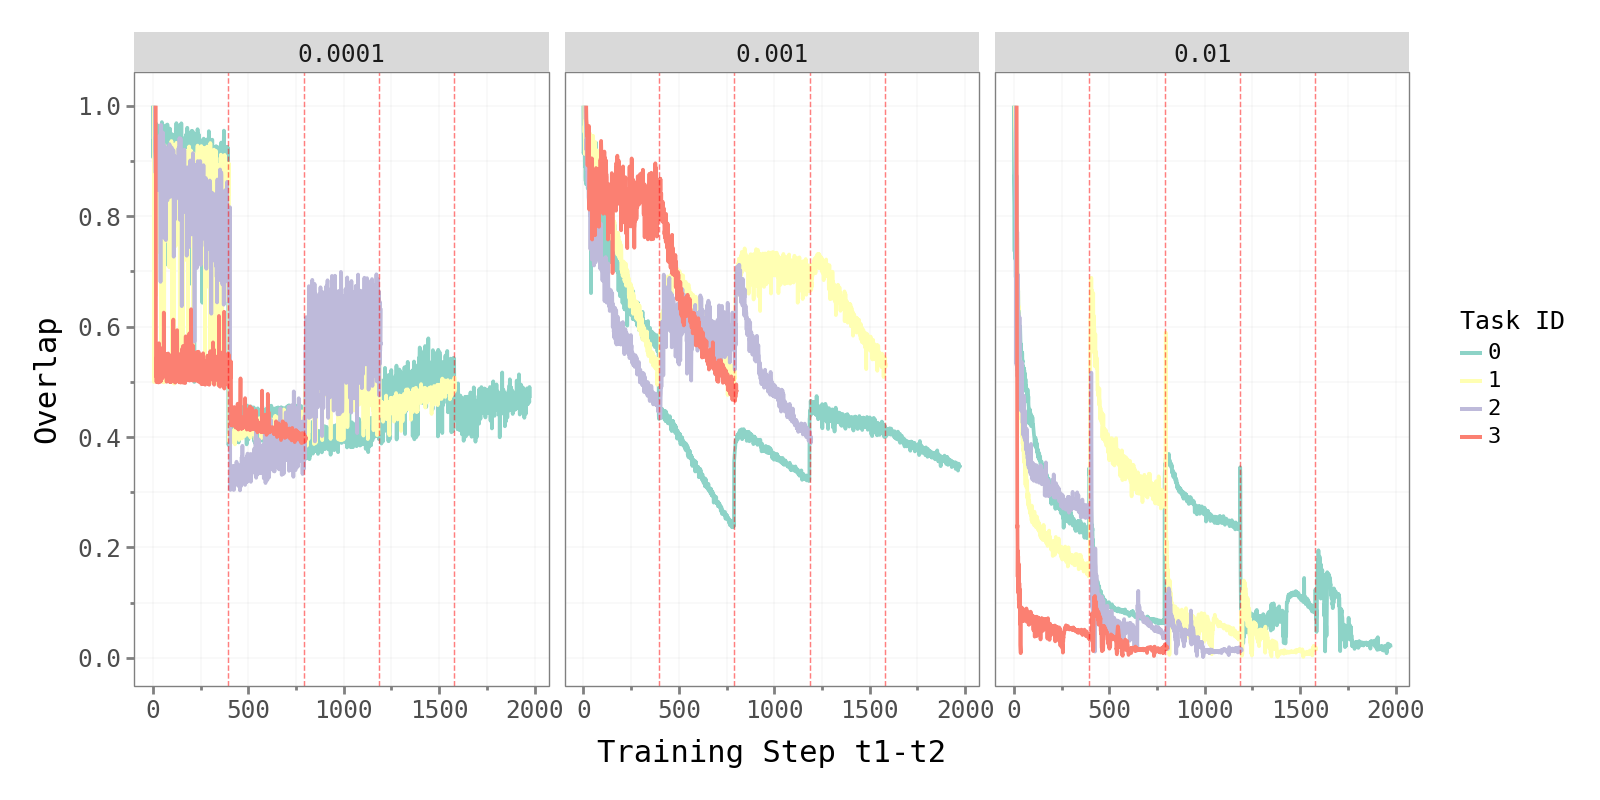

In [22]:
overlap_ablation(cifar10_main_dict['bulk']['overlaps'], cifar10_ablation_dict, CIFAR10_BOUNDARIES, "dominant", 2)

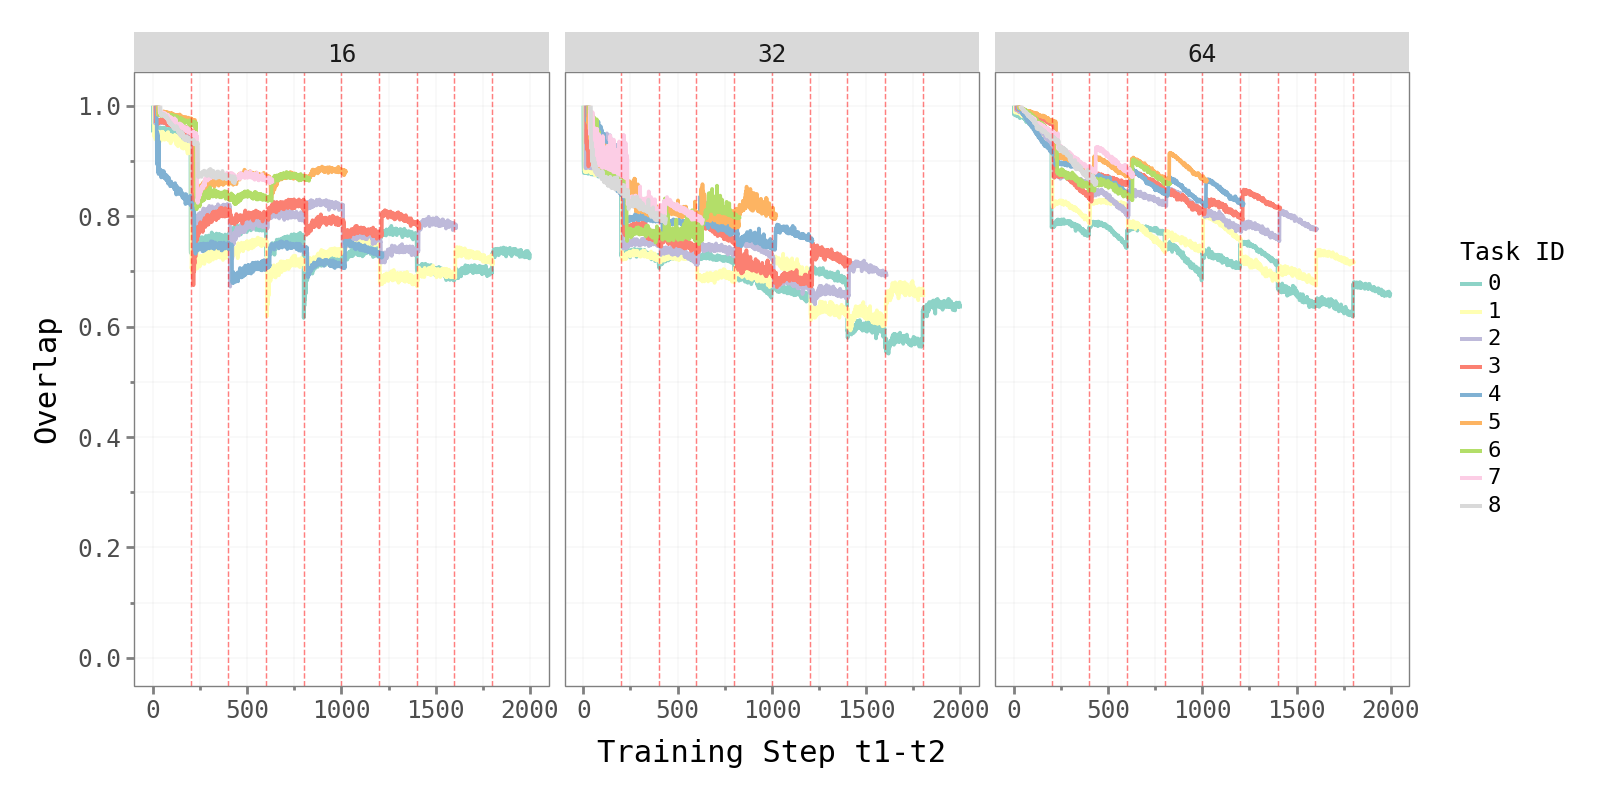

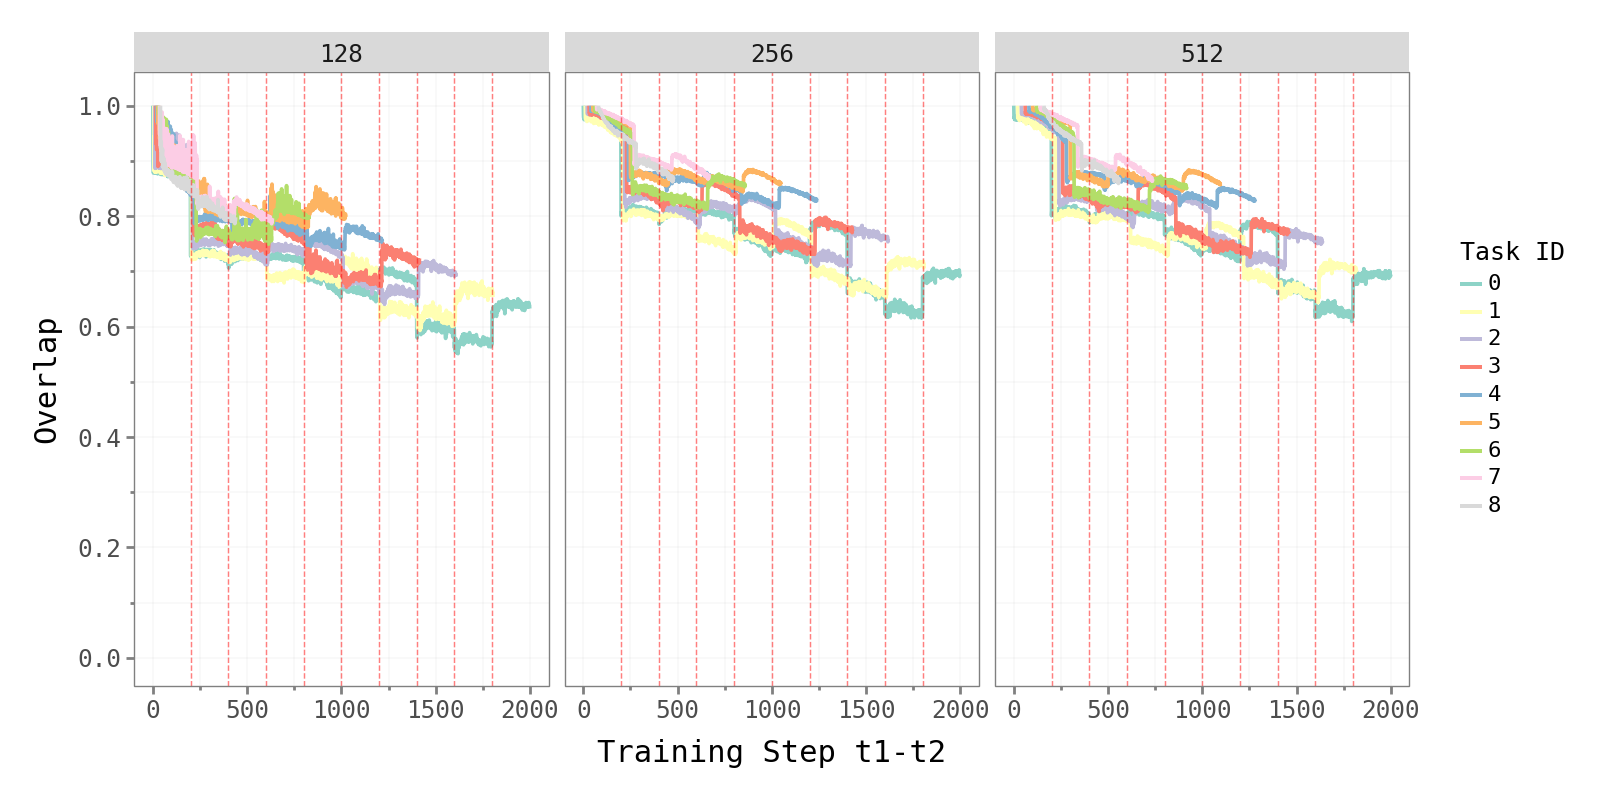

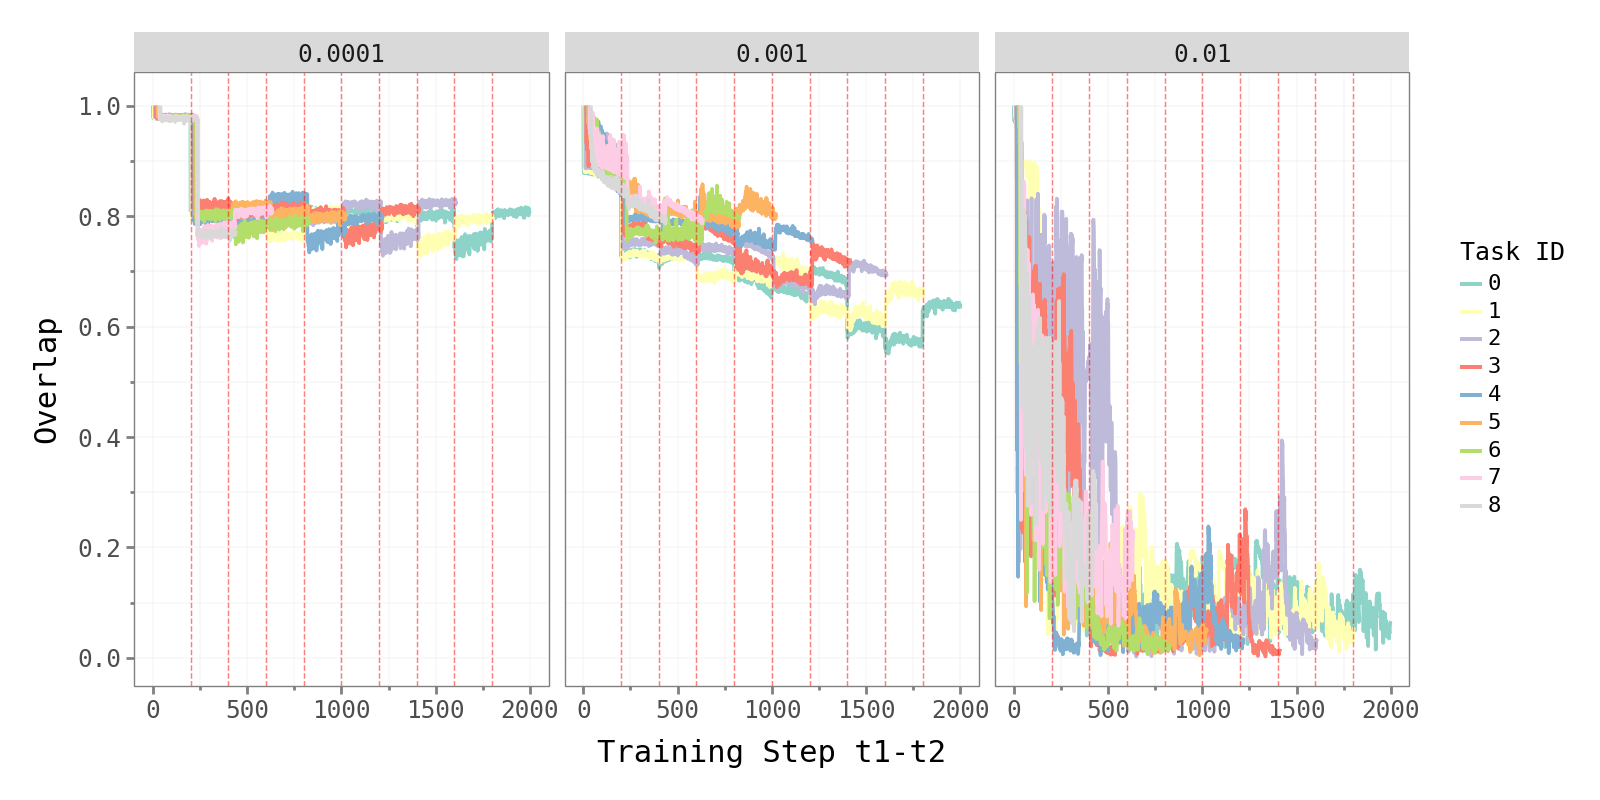

In [27]:
overlap_ablation(cifar100_main_dict['bulk']['overlaps'], cifar100_ablation_dict, CIFAR100_BOUNDARIES, "dominant", 9)